# Imports

In [ ]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.2 MB/s 


In [ ]:
# install tensorflow_addons for AdamW optimizer
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Standard libraries imports
import io
import re
import ast
import math
import gdown
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from lxml import etree
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [ ]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [ ]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


In [ ]:
# read the competition validation dataset
test_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.gold', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
test_df = test_df.iloc[:, :2]
# rename the columns
test_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in test_df.columns:
  test_df[col] = test_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
test_df.head(10)

,singular,plural
0,طربيد,طوربيدات
1,مولود,مواليد
2,ضروري,ضروريات
3,معني,معنيين
4,جدار,جدران
5,كوليس,كواليس
6,حديقة,حدائق
7,حياة,حيوات
8,دمية,دمى
9,تعاقد,تعاقدات


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hardware Detection

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# Configs

In [ ]:
# configurations class
class config:

    MAXLEN = 11 # maximum length of sequence

    # model configs
    BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
    EPOCHS = 100 # number of epochs
    LEARNING_RATE = 1E-4 # learning rate
    LEARTING_RATE_REDUCTION_PATIENCE = 10 # number of epochs to weight before lowering LR
    LEARTING_RATE_REDUCTION_FACTOR = 0.2 # LR lowering factor
    BUFFER = 1024 # buffer size for shuffling the training set
    EMBEDDING_SIZE = 256 # embedding size
    NUM_HEADS = 8 # number of heads
    NUM_BLOCKS = 4 # number of encoder blocks
    KEY_DIM = 128 # dimesion of the key, value, and query
    DROPOUT = 0.0 # dopout rate
    SKIP_RATIO = 0.0 # skip connection ratio

# Dataset

In [ ]:
final_unique_char = ['#',
                      'أ',
                      'ف',
                      'ض',
                      'ل',
                      'ا',
                      'ص',
                      'ة',
                      'ب',
                      'ع',
                      'د',
                      'ر',
                      'ي',
                      'و',
                      'ج',
                      'ه',
                      'م',
                      'ث',
                      'ت',
                      'ذ',
                      'ك',
                      'ح',
                      'ى',
                      'ق',
                      'ط',
                      'س',
                      'ش',
                      'ن',
                      'خ',
                      'غ',
                      'ظ',
                      'آ',
                      'إ',
                      'ء',
                      'ز',
                      'ئ',
                      'ؤ',
                      '|']

# list of all Arabic characters
print('Number of Arabic Characters:', len(final_unique_char))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(final_unique_char))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(final_unique_char))

char_to_index['$'] = 0 # pad
char_to_index['#'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = '$' # pad
index_to_char[1] = '#' # separator
index_to_char[2] = '_' # mask

Number of Arabic Characters: 38


In [ ]:
all_words = train_df.iloc[:, 0].values.tolist() + train_df.iloc[:, 1].values.tolist()+\
            valid_df.iloc[:, 0].values.tolist() + valid_df.iloc[:, 1].values.tolist()+\
            test_df.iloc[:, 0].values.tolist() + test_df.iloc[:, 1].values.tolist()

all_chars = []
for i in range(len(all_words)):
  all_chars.extend(all_words[i])
all_chars = list(set(list(all_chars)))

In [ ]:
for char in all_chars:
  if char not in final_unique_char:
    print(char)
    new_char = char

ٱ


In [ ]:
char_to_index[new_char] = 8
index_to_char[8] = new_char

In [ ]:
# find maximum token length in both datasets
max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(train_df)):
    if len(train_df.iloc[j, i]) > max_len:
      max_len = len(train_df.iloc[j, i])
print('Train Max Length:', max_len)

max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(valid_df)):
    if len(valid_df.iloc[j, i]) > max_len:
      max_len = len(valid_df.iloc[j, i])
print('Valid Max Length:', max_len)

Train Max Length: 11
Valid Max Length: 11


In [ ]:
def text_to_index(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    # iterate over texts
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['#']) # special separator token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        indexes.append(char_to_index['#']) # special separator token
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
def text_to_index_labels(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['#']) # special end token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
# convert text to indexes (encoder part)
enc_indexed_text_train = text_to_index(train_df.iloc[:, 0].tolist())
enc_indexed_text_valid = text_to_index(valid_df.iloc[:, 0].tolist())
enc_indexed_text_test = text_to_index(test_df.iloc[:, 0].tolist())
# pad sequences
enc_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_test = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_test, maxlen=config.MAXLEN, padding='pre')
# convert text to indexes (decoder part)
dec_indexed_text_train = text_to_index(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid = text_to_index(valid_df.iloc[:, 1].tolist())
dec_indexed_text_test = text_to_index(test_df.iloc[:, 1].tolist())
# labels for decoder (no start token)
dec_indexed_text_train_labels = text_to_index_labels(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid_labels = text_to_index_labels(valid_df.iloc[:, 1].tolist())
dec_indexed_text_test_labels = text_to_index_labels(test_df.iloc[:, 1].tolist())
# pad sequences
dec_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_test = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_test, maxlen=config.MAXLEN, padding='pre')
# pad labels
dec_indexed_text_train_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_test_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_test_labels, maxlen=config.MAXLEN, padding='pre')

100%|██████████| 600/600 [00:00<00:00, 285132.83it/s]


In [ ]:
# create a TensorFlow training dataset that performs multiple functions including
# shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_train), tf.constant(dec_indexed_text_train), tf.constant(dec_indexed_text_train_labels)))
train_ds = train_ds.shuffle(config.BUFFER).batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow validation dataset that performs multiple functions including
# batching and prefetching
valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_valid), tf.constant(dec_indexed_text_valid), tf.constant(dec_indexed_text_valid_labels)))
valid_ds = valid_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow test dataset that performs multiple functions including
# batching and prefetching
test_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_test), tf.constant(dec_indexed_text_test), tf.constant(dec_indexed_text_test_labels)))
test_ds = test_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

len(train_ds), len(valid_ds), len(test_ds)

(4, 2, 3)

# Models

## Pre-trained CBERT

Use the TensorFlow functional API to develop the CBERT model.

In [ ]:
def encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head attention layer
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)(inputs, inputs)
  # add & norm
  x = layers.Add()([inputs, x])
  x1 = layers.LayerNormalization()(x)
  # feed-forward
  x = layers.Dense(linear_shape, activation='gelu')(x1)
  x2 = layers.Dense(inputs.shape[-1], activation='linear')(x)
  # add & norm
  x = layers.Add()([x1, x2])
  x = layers.LayerNormalization()(x)
  return x

In [ ]:
with strategy.scope():
  # embedding layer that maps each input character index into a vector of the specified length
  # in the config class
  embedding_layer = layers.Embedding(input_dim=41, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
  # use another trainable embedding layer to learn positional encoding 
  pos_encoding = layers.Embedding(input_dim=41, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

In [ ]:
def encoder_model(inputs, num_blocks=4, num_heads=8, key_dim=64, dropout=0.0, skip_ratio=0.0):

    # embedding layer for characters
    embed = embedding_layer(inputs)
    # trainable positional encoding
    pos_encod = pos_encoding(tf.range(config.MAXLEN))
    # add pos_encod to embeddings
    encoded_embed = embed + pos_encod
    # multi-head attention
    mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    return mha

In [ ]:
def final_model():
  # the full CBERT model
  inputs = layers.Input(shape=(config.MAXLEN,), name='cbert_input')
  bert_output = encoder_model(inputs, num_blocks=config.NUM_BLOCKS, 
                              num_heads=config.NUM_HEADS, key_dim=config.KEY_DIM,
                              dropout=config.DROPOUT, skip_ratio=config.SKIP_RATIO)
  dense = layers.Dense(41, activation='softmax')(bert_output)

  model = tf.keras.Model(inputs=inputs, outputs=dense)
  return model

In [ ]:
# instantiate the model
cbert = final_model()
# load the pre-trained weights
url = 'https://drive.google.com/file/d/1AhVSq3LUZYlPzemlUJoBSw2-4ZsIl0UK/view?usp=sharing'
url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
output = 'final_cbert_best_weights.h5'
gdown.download(url, output, quiet=False)
cbert.load_weights('/content/final_cbert_best_weights.h5')

# define the input as the original CBERT input, and take the contextualized embeddings
# from the layer before the head
pretrained_encoder = tf.keras.Model(inputs=cbert.input, outputs=cbert.layers[-2].output)
# freeze the model weights during fine-tuning
pretrained_encoder.trainable = False

Downloading...
From: https://drive.google.com/uc?export=download&id=1AhVSq3LUZYlPzemlUJoBSw2-4ZsIl0UK
To: /content/final_cbert_best_weights.h5
100%|██████████| 18.1M/18.1M [00:00<00:00, 214MB/s]


## Full Model

In [ ]:
def main_decoder_block(inputs, cbert_output, 
                       attention_mask, num_heads=8, key_dim=64, 
                       dropout=0.0, linear_shape=128):
  # multi-head masked self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs, attention_mask=attention_mask)
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(self_att)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  # add & norm
  add = layers.Add()([self_att, ff])
  self_att_output = layers.LayerNormalization()(add)
  
  # CBERT-Decoder attention
  cbert_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=self_att_output, 
                                                             value=cbert_output, 
                                                             key=cbert_output)                                     

  # add & norm
  add = layers.Add()([self_att_output, cbert_dec_att])
  norm = layers.LayerNormalization()(add)
 
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_decoder_model(inputs, cbert_output, attention_mask):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_decoder_output = main_decoder_block(embed, cbert_output, attention_mask)

  return main_decoder_output

In [ ]:
def final_decoder_output(cbert_inputs, dec_inputs, attention_mask):

  cbert_output = pretrained_encoder(cbert_inputs)
  x = cbert_decoder_model(dec_inputs, cbert_output, attention_mask)
  x = layers.GlobalAveragePooling1D()(x)
  main_dec_output = layers.Dense(41, activation='softmax')(x)
  return main_dec_output

In [ ]:
def encoder_decoder_model():
  # put it all together
  cbert_inputs = layers.Input(shape=(config.MAXLEN,), name='enc_input')
  dec_inputs = layers.Input(shape=(config.MAXLEN,), name='dec_input')
  attention_mask = layers.Input(shape=(config.NUM_HEADS, config.MAXLEN, config.MAXLEN,), name='att_mask')

  main_dec_output = final_decoder_output(cbert_inputs, dec_inputs, attention_mask)

  model = tf.keras.Model(inputs=[cbert_inputs, dec_inputs, attention_mask], outputs=main_dec_output)
  return model

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate the model and print the summary
model = encoder_decoder_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_input (InputLayer)         [(None, 11)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 11, 256)      10496       ['dec_input[0][0]']              
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 11, 256)     0           ['embedding[1][0]']              
 da)                                                                                              
                                                                                                  
 att_mask (InputLayer)          [(None, 8, 11, 11)]  0           []                           

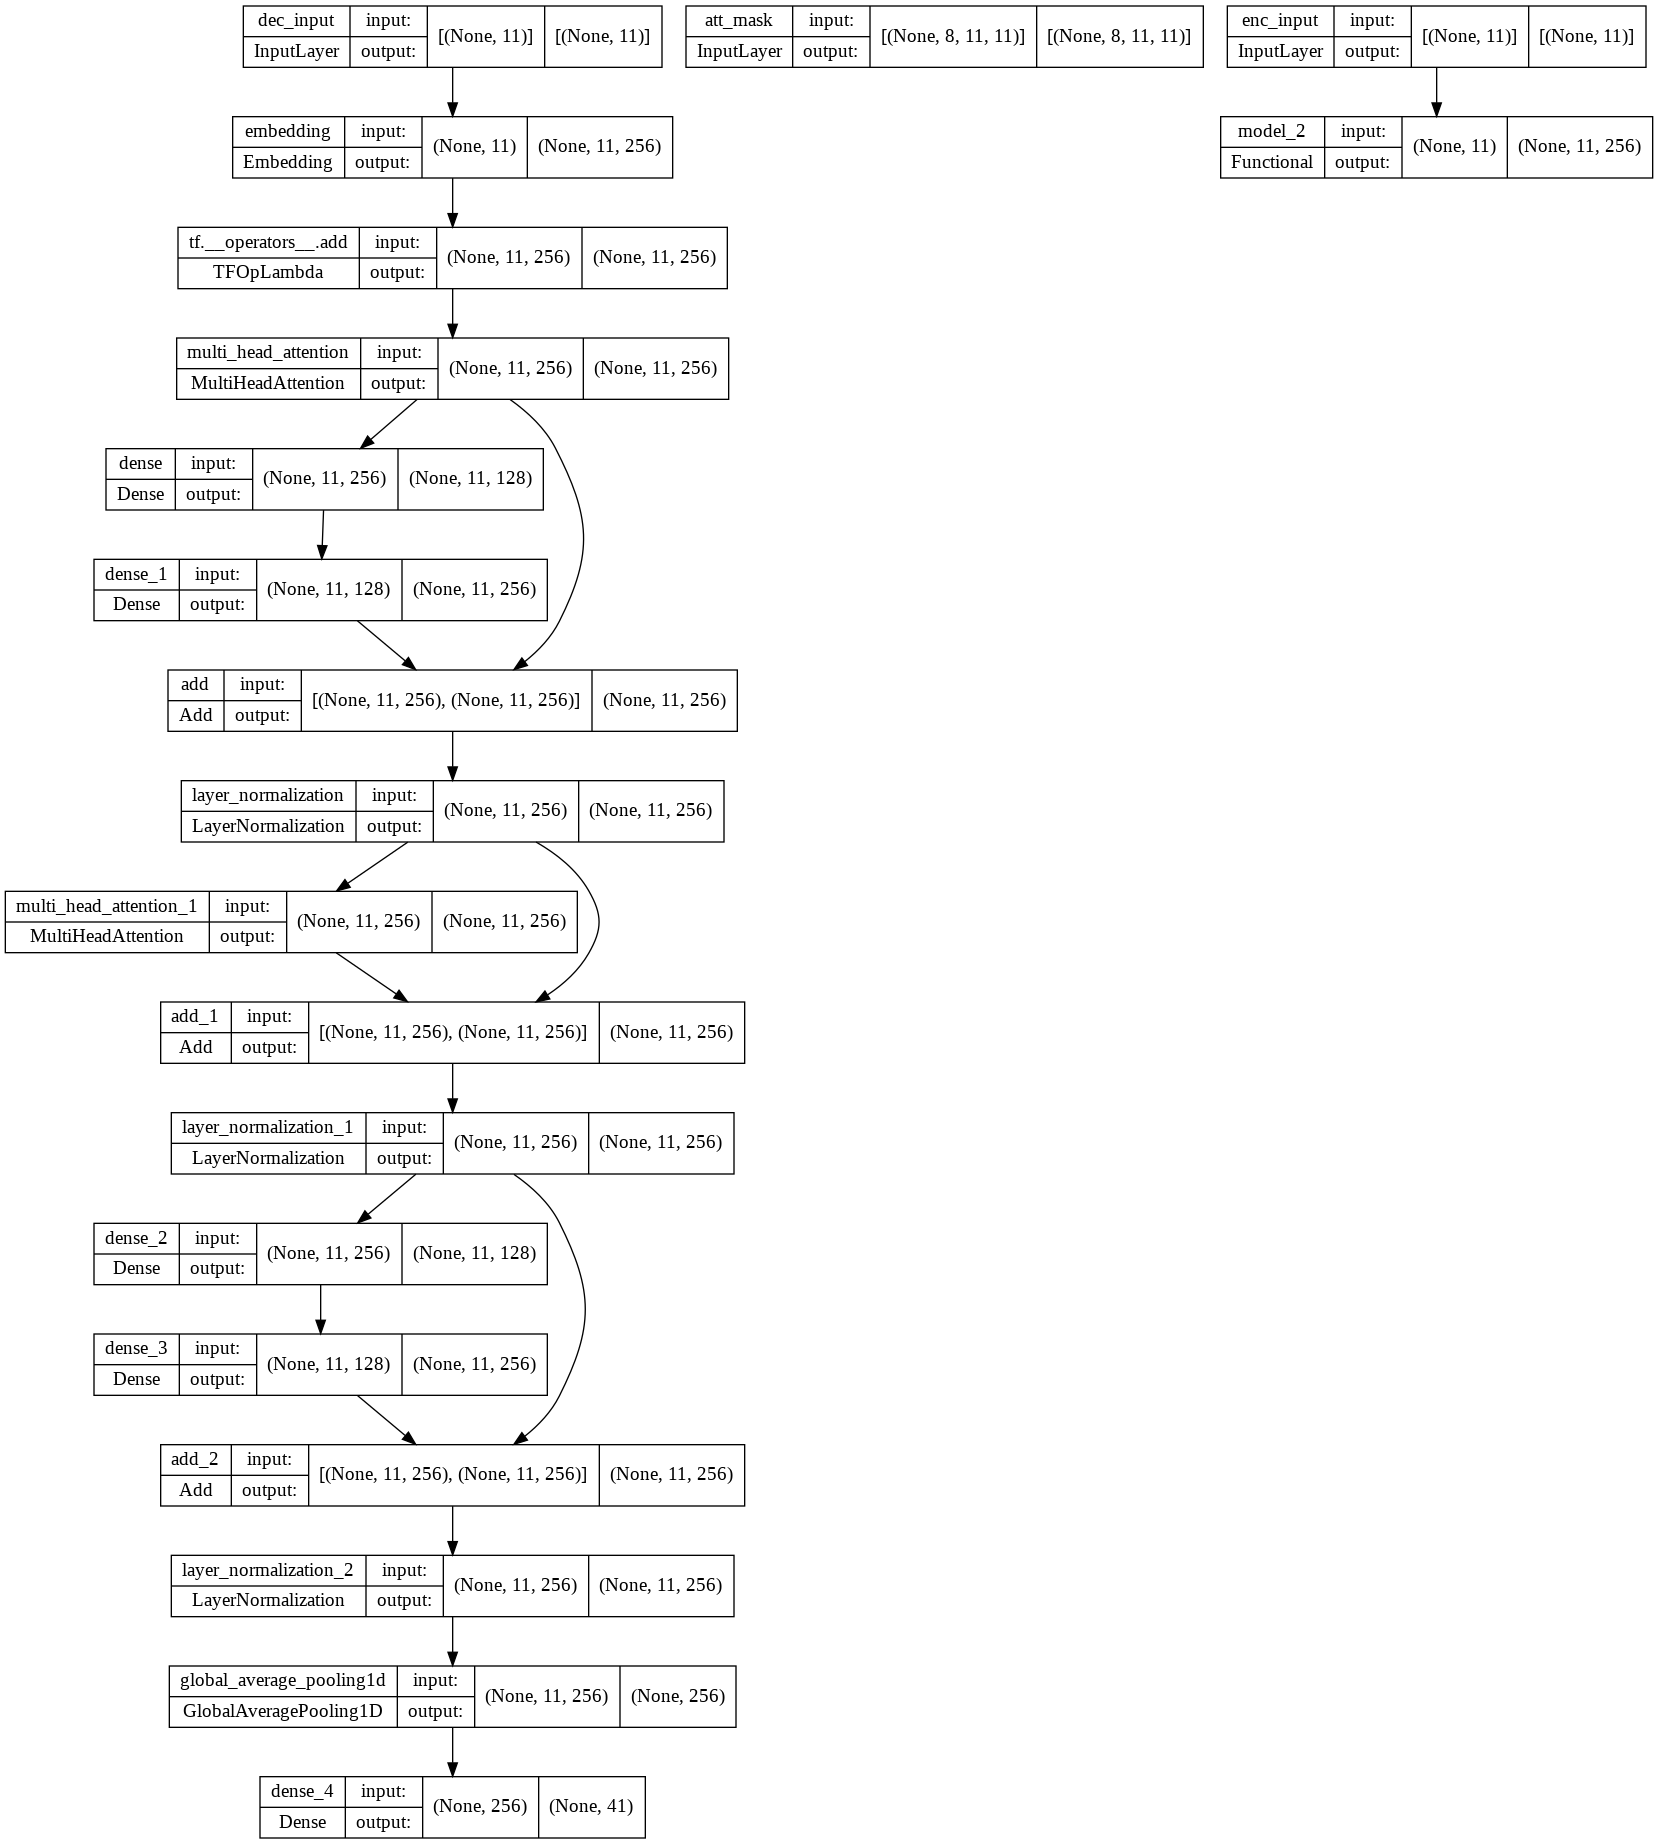

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Custom Training

## GPU

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# provide automatic class weights based on the inverse frequency 
# of each token, the more frequent, the less weight
total_num_labels = np.array(dec_indexed_text_train_labels).size
auto_weight_dict = dict()
for i in range(41):
  num_class_examples = (np.array(dec_indexed_text_train_labels) == i).sum()
  if num_class_examples != 0:
    auto_weight_dict[i] = total_num_labels / num_class_examples
  else:
    auto_weight_dict[i] = 0.1

auto_weight_dict[0] = 0.0 # give 'p' zero weight
auto_weight_dict

{0: 0.0,
 1: 11.04417670682731,
 2: 0.1,
 3: 0.1,
 4: 76.92307692307692,
 5: 87.3015873015873,
 6: 261.9047619047619,
 7: 49.549549549549546,
 8: 10.348071495766698,
 9: 132.53012048192772,
 10: 297.2972972972973,
 11: 61.79775280898876,
 12: 63.2183908045977,
 13: 66.66666666666667,
 14: 35.483870967741936,
 15: 26.829268292682926,
 16: 42.96875,
 17: 119.56521739130434,
 18: 148.64864864864865,
 19: 26.634382566585955,
 20: 478.2608695652174,
 21: 17.001545595054097,
 22: 647.0588235294117,
 23: 139.2405063291139,
 24: 91.66666666666667,
 25: 1375.0,
 26: 69.62025316455696,
 27: 132.53012048192772,
 28: 72.8476821192053,
 29: 161.76470588235293,
 30: 32.93413173652694,
 31: 229.16666666666666,
 32: 423.0769230769231,
 33: 733.3333333333334,
 34: 785.7142857142857,
 35: 323.52941176470586,
 36: 289.4736842105263,
 37: 244.44444444444446,
 38: 220.0,
 39: 916.6666666666666,
 40: 0.1}

#### Case 1: Set CBERT to "untrainable" throughout the training process

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets

full_train_losses = []
full_train_accs = []
full_train_top_k_accs = []

full_valid_losses = []
full_valid_accs = []
full_valid_top_k_accs = []

for epoch in range(config.EPOCHS):
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  full_train_losses.append(np.mean(losses))
  full_train_accs.append(np.mean(accs))
  full_train_top_k_accs.append(np.mean(top_accs))


  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  full_valid_losses.append(np.mean(losses))
  full_valid_accs.append(np.mean(accs))
  full_valid_top_k_accs.append(np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Train loss: 130.4424379197034 Train accuracy 0.041144199881025335 Train top 5 accuracy 0.18181818012486806


100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Valid loss: 4.916950117457997 Valid accuracy 0.007939034734259953 Valid top 5 accuracy 0.08212308924306523
Saving best model wieghts, Accuracy: 0.007939034734259953
Epoch: 2/100


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Train loss: 118.2552912289446 Train accuracy 0.10658307030627673 Train top 5 accuracy 0.3209247672083703


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Valid loss: 5.854299653660167 Valid accuracy 0.02338035540147261 Valid top 5 accuracy 0.16256245073269715
Saving best model wieghts, Accuracy: 0.02338035540147261
Epoch: 3/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 113.61945424025708 Train accuracy 0.15086206687952985 Train top 5 accuracy 0.34404388832097704


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Valid loss: 5.386853250590238 Valid accuracy 0.07126763327555223 Valid top 5 accuracy 0.21284368498758835
Saving best model wieghts, Accuracy: 0.07126763327555223
Epoch: 4/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 114.91037814183669 Train accuracy 0.09482758648862893 Train top 5 accuracy 0.26332288434390316


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.639935515143654 Valid accuracy 0.052193541418422355 Valid top 5 accuracy 0.23691385848955673
Accuracy didn't improve from: 0.07126763327555223
Epoch: 5/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 87.14510598507795 Train accuracy 0.1567398139952936 Train top 5 accuracy 0.36755486095154827


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.170219042084434 Valid accuracy 0.12345097010785883 Valid top 5 accuracy 0.33216594786129217
Saving best model wieghts, Accuracy: 0.12345097010785883
Epoch: 6/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 68.66917754845186 Train accuracy 0.19866771018132567 Train top 5 accuracy 0.45219436194747686


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Valid loss: 5.305924296379089 Valid accuracy 0.1324553449045528 Valid top 5 accuracy 0.333443542603742
Saving best model wieghts, Accuracy: 0.1324553449045528
Epoch: 7/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 56.05682402036407 Train accuracy 0.21630094187672844 Train top 5 accuracy 0.4706112809309905


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.226536425677213 Valid accuracy 0.13912086916918104 Valid top 5 accuracy 0.40643571791323746
Saving best model wieghts, Accuracy: 0.13912086916918104
Epoch: 8/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 57.35085591673851 Train accuracy 0.2731191196309572 Train top 5 accuracy 0.5121473391455683


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.726058298891241 Valid accuracy 0.1636624876409769 Valid top 5 accuracy 0.34003763527355413
Saving best model wieghts, Accuracy: 0.1636624876409769
Epoch: 9/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 44.59892947565425 Train accuracy 0.250783700580624 Train top 5 accuracy 0.4925548589619046


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Valid loss: 4.983338193459944 Valid accuracy 0.1707749649543654 Valid top 5 accuracy 0.39659458297220146
Saving best model wieghts, Accuracy: 0.1707749649543654
Epoch: 10/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 49.36098929426887 Train accuracy 0.286442007615485 Train top 5 accuracy 0.5364420016042211


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Valid loss: 4.965894514864141 Valid accuracy 0.1802916025573557 Valid top 5 accuracy 0.40292540074072103
Saving best model wieghts, Accuracy: 0.1802916025573557
Epoch: 11/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train loss: 40.47793824022467 Train accuracy 0.2919278990223326 Train top 5 accuracy 0.5227272789925337


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Valid loss: 4.6823843555016955 Valid accuracy 0.21570500342006033 Valid top 5 accuracy 0.4583251669325612
Saving best model wieghts, Accuracy: 0.21570500342006033
Epoch: 12/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 30.3168476738713 Train accuracy 0.33307209801436827 Train top 5 accuracy 0.5411442055112936


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.024923405864022 Valid accuracy 0.21721117435531181 Valid top 5 accuracy 0.44348182664676145
Saving best model wieghts, Accuracy: 0.21721117435531181
Epoch: 13/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 26.569464418021116 Train accuracy 0.3867554827593267 Train top 5 accuracy 0.5846395019272511


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Valid loss: 5.110254975882444 Valid accuracy 0.1850652267987078 Valid top 5 accuracy 0.4034274565902623
Accuracy didn't improve from: 0.21721117435531181
Epoch: 14/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 27.265117249705575 Train accuracy 0.3471786868335171 Train top 5 accuracy 0.5583855709145692


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.871951704675501 Valid accuracy 0.23814655129205098 Valid top 5 accuracy 0.4632253291254694
Saving best model wieghts, Accuracy: 0.23814655129205098
Epoch: 15/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 26.95375981926918 Train accuracy 0.40086205989461055 Train top 5 accuracy 0.5858150465752591


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 4.742814364758405 Valid accuracy 0.2453243388709697 Valid top 5 accuracy 0.42359138280153275
Saving best model wieghts, Accuracy: 0.2453243388709697
Epoch: 16/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 22.089538690718737 Train accuracy 0.3992946715602143 Train top 5 accuracy 0.5799372969195247


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.346987087618221 Valid accuracy 0.2496510095555674 Valid top 5 accuracy 0.4714684613387693
Saving best model wieghts, Accuracy: 0.2496510095555674
Epoch: 17/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 21.895708078687843 Train accuracy 0.38597178539599886 Train top 5 accuracy 0.5658307165246118


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 4.217617211016742 Valid accuracy 0.2855868774720214 Valid top 5 accuracy 0.49293650297278707
Saving best model wieghts, Accuracy: 0.2855868774720214
Epoch: 18/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 24.903107009150766 Train accuracy 0.34874607728455553 Train top 5 accuracy 0.520376176065342


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 4.486496965993535 Valid accuracy 0.2540899301794442 Valid top 5 accuracy 0.4679683428257704
Accuracy didn't improve from: 0.2855868774720214
Epoch: 19/100


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Train loss: 17.2782766466791 Train accuracy 0.44004702191291883 Train top 5 accuracy 0.5956112907522104


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.575564273379066 Valid accuracy 0.31043258580294525 Valid top 5 accuracy 0.5070941068909385
Saving best model wieghts, Accuracy: 0.31043258580294525
Epoch: 20/100


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Train loss: 20.383106605573133 Train accuracy 0.3824451453560455 Train top 5 accuracy 0.5830721031789753


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.610337866978212 Valid accuracy 0.309165197847919 Valid top 5 accuracy 0.5050042464651845
Accuracy didn't improve from: 0.31043258580294525
Epoch: 21/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 17.038656418973748 Train accuracy 0.3981191224249249 Train top 5 accuracy 0.5858150511472062


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.38348483226516 Valid accuracy 0.31656136008148844 Valid top 5 accuracy 0.5196190076795492
Saving best model wieghts, Accuracy: 0.31656136008148844
Epoch: 22/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 15.867692348631946 Train accuracy 0.4525862134231085 Train top 5 accuracy 0.6018808844753287


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Valid loss: 4.451361314816908 Valid accuracy 0.2956606730480086 Valid top 5 accuracy 0.4826586170291359
Accuracy didn't improve from: 0.31656136008148844
Epoch: 23/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 14.46520949493755 Train accuracy 0.4498432638885623 Train top 5 accuracy 0.5948275932195511


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.190474800088189 Valid accuracy 0.3217962214892561 Valid top 5 accuracy 0.5185638715259053
Saving best model wieghts, Accuracy: 0.3217962214892561
Epoch: 24/100


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Train loss: 13.899052611806177 Train accuracy 0.4627742958255112 Train top 5 accuracy 0.5995297737588937


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 4.412048998204145 Valid accuracy 0.3211064020341093 Valid top 5 accuracy 0.5006673657758669
Accuracy didn't improve from: 0.3217962214892561
Epoch: 25/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 16.434240861372515 Train accuracy 0.41183385612781753 Train top 5 accuracy 0.5513322867707096


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.464962143789638 Valid accuracy 0.3247126423838464 Valid top 5 accuracy 0.5071043114770543
Saving best model wieghts, Accuracy: 0.3247126423838464
Epoch: 26/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 14.279093793847345 Train accuracy 0.4545454524711452 Train top 5 accuracy 0.5897335449064319


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.707585649056868 Valid accuracy 0.3232983106916601 Valid top 5 accuracy 0.5155005041848529
Accuracy didn't improve from: 0.3247126423838464
Epoch: 27/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 13.388514627109874 Train accuracy 0.4623824476095086 Train top 5 accuracy 0.6018808750774373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.277482468973506 Valid accuracy 0.3012873892757026 Valid top 5 accuracy 0.5040511517700824
Accuracy didn't improve from: 0.3247126423838464
Epoch: 28/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 16.063085726716302 Train accuracy 0.42750783734531567 Train top 5 accuracy 0.5995297785848379


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.453511010516774 Valid accuracy 0.3166878907517953 Valid top 5 accuracy 0.5133739068088207
Accuracy didn't improve from: 0.3247126423838464
Epoch: 29/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 12.077983666550029 Train accuracy 0.48393417094749486 Train top 5 accuracy 0.6054075174880299


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Valid loss: 4.503252823244441 Valid accuracy 0.3252106166698716 Valid top 5 accuracy 0.5213741665198044
Saving best model wieghts, Accuracy: 0.3252106166698716
Epoch: 30/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 10.04336555166678 Train accuracy 0.502351101784205 Train top 5 accuracy 0.6061912187459794


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.256040360439908 Valid accuracy 0.3644731242886998 Valid top 5 accuracy 0.5345378611236811
Saving best model wieghts, Accuracy: 0.3644731242886998
Epoch: 31/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.742858136242086 Train accuracy 0.48432601780884643 Train top 5 accuracy 0.60344827005809


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Valid loss: 4.336954535408453 Valid accuracy 0.3203451538627798 Valid top 5 accuracy 0.5007836977866563
Accuracy didn't improve from: 0.3644731242886998
Epoch: 32/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.37954479726878 Train accuracy 0.4768808812156997 Train top 5 accuracy 0.587382439354604


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.3988441919738595 Valid accuracy 0.363717996430668 Valid top 5 accuracy 0.535821579566056
Accuracy didn't improve from: 0.3644731242886998
Epoch: 33/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 9.264992535114288 Train accuracy 0.4855015685104511 Train top 5 accuracy 0.6003134773874824


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 4.488676457242533 Valid accuracy 0.3686181606555527 Valid top 5 accuracy 0.5365216003900225
Saving best model wieghts, Accuracy: 0.3686181606555527
Epoch: 34/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 8.703296786004847 Train accuracy 0.48589342151006515 Train top 5 accuracy 0.6010971741581504


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.21648905087601 Valid accuracy 0.39092297039248725 Valid top 5 accuracy 0.5473974699323828
Saving best model wieghts, Accuracy: 0.39092297039248725
Epoch: 35/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.657665306871587 Train accuracy 0.4388714745556089 Train top 5 accuracy 0.5842476499012925


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.416353344917297 Valid accuracy 0.3914046152071519 Valid top 5 accuracy 0.5287703296000307
Saving best model wieghts, Accuracy: 0.3914046152071519
Epoch: 36/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 8.535810971801931 Train accuracy 0.516849534035745 Train top 5 accuracy 0.6116771152751013


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.348673874681646 Valid accuracy 0.34136216376315465 Valid top 5 accuracy 0.5321337030353871
Accuracy didn't improve from: 0.3914046152071519
Epoch: 37/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 8.11429630897262 Train accuracy 0.5227272811515088 Train top 5 accuracy 0.6132445071231235


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.420958122069186 Valid accuracy 0.34108256531709974 Valid top 5 accuracy 0.5308703956278887
Accuracy didn't improve from: 0.3914046152071519
Epoch: 38/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 8.451900758526541 Train accuracy 0.49921629912304605 Train top 5 accuracy 0.6050156696953557


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Valid loss: 4.260687557133761 Valid accuracy 0.3884167657657103 Valid top 5 accuracy 0.5505730802701279
Accuracy didn't improve from: 0.3914046152071519
Epoch: 39/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 9.417174379933964 Train accuracy 0.4796238190663809 Train top 5 accuracy 0.587382448329167


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.550074538046664 Valid accuracy 0.35280131599442527 Valid top 5 accuracy 0.539864567193118
Accuracy didn't improve from: 0.3914046152071519
Epoch: 40/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 8.85091169313951 Train accuracy 0.5078369913707402 Train top 5 accuracy 0.6069749218665741


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 4.721740644086491 Valid accuracy 0.3136490180411122 Valid top 5 accuracy 0.5078655642203309
Accuracy didn't improve from: 0.3914046152071519
Epoch: 41/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 11.016427835280245 Train accuracy 0.45336990896612406 Train top 5 accuracy 0.5830721000040119


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.580453008413315 Valid accuracy 0.3788042070174759 Valid top 5 accuracy 0.5431871273639527
Accuracy didn't improve from: 0.3914046152071519
Epoch: 42/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 8.099504457278686 Train accuracy 0.5097962451506067 Train top 5 accuracy 0.6050156685100361


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.6873267089778725 Valid accuracy 0.3761816673319448 Valid top 5 accuracy 0.5358215780420736
Accuracy didn't improve from: 0.3914046152071519
Epoch: 43/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 7.220096333460375 Train accuracy 0.532523515845903 Train top 5 accuracy 0.6101097152991728


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.560975127599456 Valid accuracy 0.3365885420617732 Valid top 5 accuracy 0.5289682930504734
Accuracy didn't improve from: 0.3914046152071519
Epoch: 44/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.59222853996537 Train accuracy 0.5364420027472079 Train top 5 accuracy 0.6124608106911182


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.442720808766105 Valid accuracy 0.36189140887422994 Valid top 5 accuracy 0.5412544096735391
Accuracy didn't improve from: 0.3914046152071519
Epoch: 45/100


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Train loss: 6.630970935929906 Train accuracy 0.5376175587404181 Train top 5 accuracy 0.6155956109816377


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Valid loss: 4.460500902750275 Valid accuracy 0.3615669073028998 Valid top 5 accuracy 0.5423401550135829
Accuracy didn't improve from: 0.3914046152071519
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 46/100


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Train loss: 5.7048428004438225 Train accuracy 0.5364420068111609 Train top 5 accuracy 0.6199059520255435


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Valid loss: 4.409786340865222 Valid accuracy 0.4005559379742904 Valid top 5 accuracy 0.5551793531260707
Saving best model wieghts, Accuracy: 0.4005559379742904
Epoch: 47/100


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Train loss: 5.438402109525421 Train accuracy 0.5407523519190197 Train top 5 accuracy 0.6246081475507129


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Valid loss: 4.391845457933166 Valid accuracy 0.3961272207512097 Valid top 5 accuracy 0.5565896017307584
Accuracy didn't improve from: 0.4005559379742904
Epoch: 48/100


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Train loss: 5.270069856535304 Train accuracy 0.5458463924428956 Train top 5 accuracy 0.6304858909411863


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.418611999262463 Valid accuracy 0.3882494137029756 Valid top 5 accuracy 0.5571426827121865
Accuracy didn't improve from: 0.4005559379742904
Epoch: 49/100


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Train loss: 5.153260611675003 Train accuracy 0.5458463978614997 Train top 5 accuracy 0.6355799375609918


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Valid loss: 4.434869974851608 Valid accuracy 0.38683916509828786 Valid top 5 accuracy 0.5595876613462513
Accuracy didn't improve from: 0.4005559379742904
Epoch: 50/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.058832795782522 Train accuracy 0.5481974922374568 Train top 5 accuracy 0.6391065818342295


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.451774322173812 Valid accuracy 0.3838819212872874 Valid top 5 accuracy 0.5617081360383467
Accuracy didn't improve from: 0.4005559379742904
Epoch: 51/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.983238860964775 Train accuracy 0.5497648942453618 Train top 5 accuracy 0.6418495293367993


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.476922690868378 Valid accuracy 0.38196961615573277 Valid top 5 accuracy 0.5638388210738247
Accuracy didn't improve from: 0.4005559379742904
Epoch: 52/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.899161821061915 Train accuracy 0.5501567460173233 Train top 5 accuracy 0.6434169269420884


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 4.489177510142326 Valid accuracy 0.38426765156063164 Valid top 5 accuracy 0.5666389146989043
Accuracy didn't improve from: 0.4005559379742904
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.783481379801577 Train accuracy 0.5509404414333403 Train top 5 accuracy 0.643808776004748


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Valid loss: 4.498703314499422 Valid accuracy 0.39034947990016505 Valid top 5 accuracy 0.5690736862068827
Accuracy didn't improve from: 0.4005559379742904
Epoch: 54/100


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Train loss: 4.667265008796345 Train accuracy 0.5521159863776781 Train top 5 accuracy 0.6449843204834245


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.525290864435109 Valid accuracy 0.38982701674103737 Valid top 5 accuracy 0.5683838669210672
Accuracy didn't improve from: 0.4005559379742904
Epoch: 55/100


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Train loss: 4.566161074421623 Train accuracy 0.5536833826283162 Train top 5 accuracy 0.6473354168913581


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Valid loss: 4.540078312158585 Valid accuracy 0.39105970768088644 Valid top 5 accuracy 0.573116675357927
Accuracy didn't improve from: 0.4005559379742904
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.480242604559118 Train accuracy 0.5548589271069928 Train top 5 accuracy 0.6512539156458594


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Valid loss: 4.551686262542551 Valid accuracy 0.39299242418598046 Valid top 5 accuracy 0.573639140887694
Accuracy didn't improve from: 0.4005559379742904
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 57/100


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Train loss: 4.290529106150974 Train accuracy 0.5540752344002778 Train top 5 accuracy 0.6489028185606003


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 4.48436307229779 Valid accuracy 0.4029805050654845 Valid top 5 accuracy 0.576982108368115
Saving best model wieghts, Accuracy: 0.4029805050654845
Epoch: 58/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train loss: 4.246873381462964 Train accuracy 0.5540752344002778 Train top 5 accuracy 0.6481191177259792


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 4.500851688059893 Valid accuracy 0.4058010031215169 Valid top 5 accuracy 0.5766167911616239
Saving best model wieghts, Accuracy: 0.4058010031215169
Epoch: 59/100


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Train loss: 4.223113549026576 Train accuracy 0.5540752289816737 Train top 5 accuracy 0.6481191177259792


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Valid loss: 4.495474082502452 Valid accuracy 0.4057907998900522 Valid top 5 accuracy 0.577149460600181
Accuracy didn't improve from: 0.4058010031215169
Epoch: 60/100


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Train loss: 4.200103423812172 Train accuracy 0.5544670807536353 Train top 5 accuracy 0.6481191177259792


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Valid loss: 4.503120632334189 Valid accuracy 0.4054458899931474 Valid top 5 accuracy 0.5768045512112704
Accuracy didn't improve from: 0.4058010031215169
Epoch: 61/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.177539043805816 Train accuracy 0.5544670807536353 Train top 5 accuracy 0.6485109667886387


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Valid loss: 4.508136559616435 Valid accuracy 0.4052683331749656 Valid top 5 accuracy 0.5773270170797001
Accuracy didn't improve from: 0.4058010031215169
Epoch: 62/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 4.1553266454826705 Train accuracy 0.5552507734603502 Train top 5 accuracy 0.6496865153312683


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 4.5139565928415815 Valid accuracy 0.4042234027927572 Valid top 5 accuracy 0.5775045738978819
Accuracy didn't improve from: 0.4058010031215169
Epoch: 63/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 4.133460051634095 Train accuracy 0.5552507734603502 Train top 5 accuracy 0.6500783643939279


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.524928359822794 Valid accuracy 0.40317846834659576 Valid top 5 accuracy 0.5775147771293466
Accuracy didn't improve from: 0.4058010031215169
Epoch: 64/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 4.111903403293002 Train accuracy 0.5556426252323118 Train top 5 accuracy 0.6500783643939279


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.529179340059107 Valid accuracy 0.4033560251647776 Valid top 5 accuracy 0.5773372203111649
Accuracy didn't improve from: 0.4058010031215169
Epoch: 65/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 4.090624138712883 Train accuracy 0.5560344715856693 Train top 5 accuracy 0.6504702148112383


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Valid loss: 4.533132637088949 Valid accuracy 0.40371113880114123 Valid top 5 accuracy 0.5780474475838921
Accuracy didn't improve from: 0.4058010031215169
Epoch: 66/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 4.069596514105797 Train accuracy 0.5560344715856693 Train top 5 accuracy 0.6504702148112383


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.537626867944544 Valid accuracy 0.4040662524375049 Valid top 5 accuracy 0.5791025852615183
Accuracy didn't improve from: 0.4058010031215169
Epoch: 67/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 4.048796493898738 Train accuracy 0.5564263233576309 Train top 5 accuracy 0.6512539170005105


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.53915186361833 Valid accuracy 0.40527853911573236 Valid top 5 accuracy 0.5789250297979875
Accuracy didn't improve from: 0.4058010031215169
Epoch: 68/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 4.028207819570195 Train accuracy 0.5568181751295924 Train top 5 accuracy 0.6512539170005105


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.544703071767634 Valid accuracy 0.40527853911573236 Valid top 5 accuracy 0.5789250297979875
Accuracy didn't improve from: 0.4058010031215169
model didn't improve for 10 epochs----> lower learning rate to 8.000000000000002e-07
Epoch: 69/100


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Train loss: 3.9547326510602776 Train accuracy 0.556426334194839 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 4.553632855415344 Valid accuracy 0.4061765264381062 Valid top 5 accuracy 0.5750698005272583
Saving best model wieghts, Accuracy: 0.4061765264381062
Epoch: 70/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.9523010199720208 Train accuracy 0.5564263287762349 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.556396930055185 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 71/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.948458244854754 Train accuracy 0.5564263287762349 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Valid loss: 4.558038181879303 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 72/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 3.9444000599059192 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.5594687190922825 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 73/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.940282016992569 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.560821453278715 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 74/100


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Train loss: 3.9361479458483783 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.562192430550402 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 75/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 3.9320133463902907 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.563438492742452 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 76/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 3.927881133827296 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 4.564645731990987 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 77/100


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Train loss: 3.9237539172172546 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.565822490236976 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5750698005272583
Accuracy didn't improve from: 0.4061765264381062
Epoch: 78/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 3.919631627472964 Train accuracy 0.5568181805481965 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.566977247595787 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 79/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 3.9155134707689285 Train accuracy 0.5572100323201581 Train top 5 accuracy 0.6512539170005105


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.568116574124857 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
model didn't improve for 10 epochs----> lower learning rate to 1.6000000000000006e-07
Epoch: 80/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.9030728421427985 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 4.570158390836283 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 81/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 3.90229311179031 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 4.569997681812807 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 82/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.901467977599664 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.570353245193308 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 83/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.900637140328234 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.570685103535652 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 84/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 3.8998073122718115 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.570997572757981 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 85/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 3.8989785530350427 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.571294221011075 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 86/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.8981508531353692 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.5715785609050235 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 87/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.897324315526269 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.571852948177945 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.896497516469522 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 4.5721191587773236 Valid accuracy 0.40582141297107394 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 89/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 3.895671856674281 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.572099043564363 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 90/100


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Train loss: 3.8948456970128147 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.572353371165016 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 91/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 3.894019529223442 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.572603923353282 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 92/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.893193533474749 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.572850992733782 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 93/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.892367297952825 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.573095621033148 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 94/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.8915411233901978 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.57333755357699 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 95/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.8907156762751667 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Valid loss: 4.573577347126874 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5747146868908947
Accuracy didn't improve from: 0.4061765264381062
Epoch: 96/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 3.8898896114392714 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 4.573759856549176 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 97/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 3.8890641277486626 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.573996840552851 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 98/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 3.888238327069716 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.574232675812461 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 99/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.8874130601232704 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.574467902833765 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062
Epoch: 100/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 3.8865875615315004 Train accuracy 0.557210026901554 Train top 5 accuracy 0.6508620665831999


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

Valid loss: 4.574701883576133 Valid accuracy 0.4054662993347103 Valid top 5 accuracy 0.5748922437090765
Accuracy didn't improve from: 0.4061765264381062


In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_direct_case_1.csv', index=False)

!mv /content/final_validation_set_train_progress_direct_case_1.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

{'loss': 4.5608367919921875, 'sparse_categorical_accuracy': 0.40551286935806274, 'top_k_acc': 0.578849732875824}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_direct_case_1.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_direct_case_1.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

{'loss': 4.571964263916016, 'sparse_categorical_accuracy': 0.40017351508140564, 'top_k_acc': 0.5776535272598267}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_direct_case_1.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_direct_case_1.npy /content/drive/MyDrive/NLP_Course

#### Case 2: Set CBERT to "untrainable" during the first 50 epochs then set it to "trainable"

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  if epoch == 50:
    print('*'*70)
    print(f'Fine-tuning all layers with LR = {5e-5}')
    model.trainable = True
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=metrics,
                  optimizer=tfa.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.0))
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 129.88573363694277 Train accuracy 0.06739811798218977 Train top 5 accuracy 0.2260971776717766


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 4.841657064177773 Valid accuracy 0.013924944468519905 Valid top 5 accuracy 0.18624689802527428
Saving best model wieghts, Accuracy: 0.013924944468519905
Epoch: 2/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 118.96358433907682 Train accuracy 0.07836990477517247 Train top 5 accuracy 0.2844827626408501


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.253573081710122 Valid accuracy 0.033972537822344086 Valid top 5 accuracy 0.2184132540767843
Saving best model wieghts, Accuracy: 0.033972537822344086
Epoch: 3/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 120.49767780845815 Train accuracy 0.042711598417637026 Train top 5 accuracy 0.27037617708133027


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 5.325096076185053 Valid accuracy 0.013569830832156267 Valid top 5 accuracy 0.19233485125005245
Accuracy didn't improve from: 0.033972537822344086
Epoch: 4/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 97.28842941197482 Train accuracy 0.13244514137675817 Train top 5 accuracy 0.33503134607930074


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.884407661177895 Valid accuracy 0.07047577134587547 Valid top 5 accuracy 0.2895992523567243
Saving best model wieghts, Accuracy: 0.07047577134587547
Epoch: 5/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 90.11766982078552 Train accuracy 0.14851097428155216 Train top 5 accuracy 0.3667711591432718


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 5.921873179349032 Valid accuracy 0.0721350083635612 Valid top 5 accuracy 0.2569716577841477
Saving best model wieghts, Accuracy: 0.0721350083635612
Epoch: 6/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 70.68732678890228 Train accuracy 0.20650470146740024 Train top 5 accuracy 0.40869905812327156


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.631504275582054 Valid accuracy 0.08876820416613058 Valid top 5 accuracy 0.3691508297554471
Saving best model wieghts, Accuracy: 0.08876820416613058
Epoch: 7/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 57.63988829200918 Train accuracy 0.23667711489410562 Train top 5 accuracy 0.4443573678251017


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.332684755325317 Valid accuracy 0.10017674026841467 Valid top 5 accuracy 0.39216586761176586
Saving best model wieghts, Accuracy: 0.10017674026841467
Epoch: 8/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 63.47035051746802 Train accuracy 0.19553291590207003 Train top 5 accuracy 0.37970219933512533


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.083366524089467 Valid accuracy 0.17477713525295258 Valid top 5 accuracy 0.3973252217877995
Saving best model wieghts, Accuracy: 0.17477713525295258
Epoch: 9/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 39.04886783523993 Train accuracy 0.30054859101602976 Train top 5 accuracy 0.5368338609114289


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.8316229365088725 Valid accuracy 0.17763845165344802 Valid top 5 accuracy 0.41695647161792626
Saving best model wieghts, Accuracy: 0.17763845165344802
Epoch: 10/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 40.751518141139634 Train accuracy 0.31700626629489387 Train top 5 accuracy 0.5521159838800404


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.678720457987352 Valid accuracy 0.1750261245126074 Valid top 5 accuracy 0.4129685854369944
Accuracy didn't improve from: 0.17763845165344802
Epoch: 11/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 38.79935882308266 Train accuracy 0.2993730445053767 Train top 5 accuracy 0.5274294700304215


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 5.0163145227865735 Valid accuracy 0.2288829848508943 Valid top 5 accuracy 0.4254587915810672
Saving best model wieghts, Accuracy: 0.2288829848508943
Epoch: 12/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 41.62927348234437 Train accuracy 0.3193573691797527 Train top 5 accuracy 0.49804075316272


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 5.061954417011955 Valid accuracy 0.2208174162290313 Valid top 5 accuracy 0.45460668494078244
Accuracy didn't improve from: 0.2288829848508943
Epoch: 13/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 27.902579353614286 Train accuracy 0.37852664321491664 Train top 5 accuracy 0.5623040740293536


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.056645480069247 Valid accuracy 0.22485019859265198 Valid top 5 accuracy 0.4443798173557628
Accuracy didn't improve from: 0.2288829848508943
Epoch: 14/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 29.929033114151522 Train accuracy 0.3781347926282747 Train top 5 accuracy 0.5638714729892936


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.978761247613213 Valid accuracy 0.2104538089849732 Valid top 5 accuracy 0.4487166948277842
Accuracy didn't improve from: 0.2288829848508943
Epoch: 15/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 21.539972887797788 Train accuracy 0.3965517236343162 Train top 5 accuracy 0.5920846380124037


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.695172377608039 Valid accuracy 0.257087988440286 Valid top 5 accuracy 0.4584312963892113
Saving best model wieghts, Accuracy: 0.257087988440286
Epoch: 16/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 23.1723989573392 Train accuracy 0.389106585517187 Train top 5 accuracy 0.58032915529541


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.68689651651816 Valid accuracy 0.2633024755526673 Valid top 5 accuracy 0.48957313055341894
Saving best model wieghts, Accuracy: 0.2633024755526673
Epoch: 17/100


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Train loss: 23.933456800200723 Train accuracy 0.36010971627282823 Train top 5 accuracy 0.5411442002620209


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.478212882171977 Valid accuracy 0.2854093192991885 Valid top 5 accuracy 0.48782817426730285
Saving best model wieghts, Accuracy: 0.2854093192991885
Epoch: 18/100


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Train loss: 21.186079583384775 Train accuracy 0.40673981547694316 Train top 5 accuracy 0.5787617518481883


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.700251590121876 Valid accuracy 0.28187859312377195 Valid top 5 accuracy 0.4776319217952815
Accuracy didn't improve from: 0.2854093192991885
Epoch: 19/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 16.78031140024012 Train accuracy 0.44670847206461156 Train top 5 accuracy 0.5995297751558776


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Valid loss: 4.93440845337781 Valid accuracy 0.27439671297642315 Valid top 5 accuracy 0.4936263176866553
Accuracy didn't improve from: 0.2854093192991885
Epoch: 20/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 19.320653836835515 Train accuracy 0.4529780685393648 Train top 5 accuracy 0.5787617572667924


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 5.009963051839308 Valid accuracy 0.2830459759993987 Valid top 5 accuracy 0.48397294398058543
Accuracy didn't improve from: 0.2854093192991885
Epoch: 21/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 21.96070842851292 Train accuracy 0.3679467067545788 Train top 5 accuracy 0.5415360486473549


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.97766203771938 Valid accuracy 0.2939769468185576 Valid top 5 accuracy 0.506079787388444
Saving best model wieghts, Accuracy: 0.2939769468185576
Epoch: 22/100


100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Train loss: 18.42004564675418 Train accuracy 0.40478056495670567 Train top 5 accuracy 0.5611285266720436


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.649587195027959 Valid accuracy 0.33374763144688174 Valid top 5 accuracy 0.5157433697445826
Saving best model wieghts, Accuracy: 0.33374763144688174
Epoch: 23/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 13.708082570271058 Train accuracy 0.4525862032632259 Train top 5 accuracy 0.5999216355214064


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Valid loss: 4.6430849730968475 Valid accuracy 0.3260984038087455 Valid top 5 accuracy 0.5136024823242967
Accuracy didn't improve from: 0.33374763144688174
Epoch: 24/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.840829648754813 Train accuracy 0.45532915161245247 Train top 5 accuracy 0.6061912232332609


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.61211311546239 Valid accuracy 0.3217105047607964 Valid top 5 accuracy 0.5183659033341841
Accuracy didn't improve from: 0.33374763144688174
Epoch: 25/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 14.15559241717512 Train accuracy 0.4518025103448467 Train top 5 accuracy 0.5983542289415543


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.918851846998388 Valid accuracy 0.2958341503346508 Valid top 5 accuracy 0.49485901675441046
Accuracy didn't improve from: 0.33374763144688174
Epoch: 26/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.877824845639141 Train accuracy 0.46394984280182555 Train top 5 accuracy 0.5862068921666254


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Valid loss: 4.847869119860909 Valid accuracy 0.32764539342712273 Valid top 5 accuracy 0.5134963569315997
Accuracy didn't improve from: 0.33374763144688174
Epoch: 27/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 12.94047563997182 Train accuracy 0.4467084704982964 Train top 5 accuracy 0.5799372989515011


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.73756128820506 Valid accuracy 0.356687156483531 Valid top 5 accuracy 0.528435621241277
Saving best model wieghts, Accuracy: 0.356687156483531
Epoch: 28/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 14.522776877338236 Train accuracy 0.4486677144992758 Train top 5 accuracy 0.5740595702928576


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Valid loss: 4.770841070196846 Valid accuracy 0.3215125406330282 Valid top 5 accuracy 0.5202986195006154
Accuracy didn't improve from: 0.356687156483531
Epoch: 29/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 15.930461179126393 Train accuracy 0.4157523544166576 Train top 5 accuracy 0.5764106574722312


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.879473919218237 Valid accuracy 0.3538564555346966 Valid top 5 accuracy 0.5236619968305934
Accuracy didn't improve from: 0.356687156483531
Epoch: 30/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.965818757360632 Train accuracy 0.4690438807857307 Train top 5 accuracy 0.5991379297761754


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Valid loss: 4.82717230645093 Valid accuracy 0.3847390941598199 Valid top 5 accuracy 0.5340153928846121
Saving best model wieghts, Accuracy: 0.3847390941598199
Epoch: 31/100


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Train loss: 10.152656595815312 Train accuracy 0.4804075214249844 Train top 5 accuracy 0.6050156792625785


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.824208458716219 Valid accuracy 0.35881784016435797 Valid top 5 accuracy 0.5368563070554625
Accuracy didn't improve from: 0.3847390941598199
Epoch: 32/100


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Train loss: 9.994147354906255 Train accuracy 0.5105799415402792 Train top 5 accuracy 0.6085423193871975


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.254099247130481 Valid accuracy 0.29630559428849 Valid top 5 accuracy 0.48036057739095256
Accuracy didn't improve from: 0.3847390941598199
Epoch: 33/100


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Train loss: 8.76266529343345 Train accuracy 0.49725706257264723 Train top 5 accuracy 0.606583073227243


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.890826776623726 Valid accuracy 0.37102231721986423 Valid top 5 accuracy 0.5401890675791285
Accuracy didn't improve from: 0.3847390941598199
Epoch: 34/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 9.07914776964621 Train accuracy 0.49216300731694157 Train top 5 accuracy 0.6065830731425773


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.89291048320857 Valid accuracy 0.34382755258543923 Valid top 5 accuracy 0.5307030386545442
Accuracy didn't improve from: 0.3847390941598199
Epoch: 35/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 11.436292252757333 Train accuracy 0.4784482709894126 Train top 5 accuracy 0.6030564243820581


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 5.030049798163501 Valid accuracy 0.3485909759659659 Valid top 5 accuracy 0.525615122507919
Accuracy didn't improve from: 0.3847390941598199
Epoch: 36/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 7.956307665868239 Train accuracy 0.5074451402337714 Train top 5 accuracy 0.606191223741255


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.047580794854597 Valid accuracy 0.3979885063388131 Valid top 5 accuracy 0.5398033412004059
Saving best model wieghts, Accuracy: 0.3979885063388131
Epoch: 37/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 9.340264301408421 Train accuracy 0.48119122526523744 Train top 5 accuracy 0.5991379301148382


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.185341301289472 Valid accuracy 0.3801430247046731 Valid top 5 accuracy 0.5359072969718413
Accuracy didn't improve from: 0.3979885063388131
Epoch: 38/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 7.6234748200936755 Train accuracy 0.5023511003872211 Train top 5 accuracy 0.6057993700219826


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.063042396848852 Valid accuracy 0.3962639570236206 Valid top 5 accuracy 0.5399911048060114
Accuracy didn't improve from: 0.3979885063388131
Epoch: 39/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 8.205513497645205 Train accuracy 0.5078369953923605 Train top 5 accuracy 0.6010971782221035


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 5.518816540187055 Valid accuracy 0.32950667867606337 Valid top 5 accuracy 0.5092247936197303
Accuracy didn't improve from: 0.3979885063388131
Epoch: 40/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.394724322990937 Train accuracy 0.49804075210439885 Train top 5 accuracy 0.5975705261596225


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.221954956650734 Valid accuracy 0.37890012663873757 Valid top 5 accuracy 0.533472521907904
Accuracy didn't improve from: 0.3979885063388131
Epoch: 41/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.611325213854963 Train accuracy 0.5246865218505263 Train top 5 accuracy 0.6077586209232156


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.376561996611682 Valid accuracy 0.3569606386802413 Valid top 5 accuracy 0.531560211696408
Accuracy didn't improve from: 0.3979885063388131
Epoch: 42/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.022534183480523 Train accuracy 0.49921629908071324 Train top 5 accuracy 0.6077586153352802


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 5.4587080722505394 Valid accuracy 0.3156225501813672 Valid top 5 accuracy 0.5323765707964246
Accuracy didn't improve from: 0.3979885063388131
Epoch: 43/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 6.481517107649283 Train accuracy 0.5289968718689951 Train top 5 accuracy 0.607366771352562


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.254606540907513 Valid accuracy 0.394904731518843 Valid top 5 accuracy 0.5454443410377611
Accuracy didn't improve from: 0.3979885063388131
Epoch: 44/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 6.554904168302363 Train accuracy 0.5282131722196937 Train top 5 accuracy 0.609717863865874


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.162484923546964 Valid accuracy 0.3696528844196688 Valid top 5 accuracy 0.5380992047827352
Accuracy didn't improve from: 0.3979885063388131
Epoch: 45/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 6.043472489172762 Train accuracy 0.5364420018582181 Train top 5 accuracy 0.6105015674097971


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 5.133284952152859 Valid accuracy 0.37281829660589044 Valid top 5 accuracy 0.5435116221620278
Accuracy didn't improve from: 0.3979885063388131
Epoch: 46/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.261900729753754 Train accuracy 0.528996866450391 Train top 5 accuracy 0.6085423188792034


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.234192963350903 Valid accuracy 0.3669895353642377 Valid top 5 accuracy 0.545748430388895
Accuracy didn't improve from: 0.3979885063388131
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 47/100


100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Train loss: 5.398880935528061 Train accuracy 0.5399686461314559 Train top 5 accuracy 0.6093260208991441


100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Valid loss: 5.326034965840253 Valid accuracy 0.3864738421345299 Valid top 5 accuracy 0.5451198404824192
Accuracy didn't improve from: 0.3979885063388131
Epoch: 48/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 5.179738563570109 Train accuracy 0.5380094035274603 Train top 5 accuracy 0.6093260208991441


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Valid loss: 5.3454927463423125 Valid accuracy 0.3847390944984826 Valid top 5 accuracy 0.5438871486959133
Accuracy didn't improve from: 0.3979885063388131
Epoch: 49/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train loss: 5.053209945559502 Train accuracy 0.5403604979034174 Train top 5 accuracy 0.6093260208991441


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 5.3631128235296766 Valid accuracy 0.38663099333643913 Valid top 5 accuracy 0.5442320577461611
Accuracy didn't improve from: 0.3979885063388131
Epoch: 50/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 4.942998028614304 Train accuracy 0.5419278995726596 Train top 5 accuracy 0.6097178672525015


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 5.400060058994726 Valid accuracy 0.38576361824843014 Valid top 5 accuracy 0.5447545236145909
Accuracy didn't improve from: 0.3979885063388131
**********************************************************************
Fine-tuning all layers with LR = 5e-05
Epoch: 51/100


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


Train loss: 24.29889141158624 Train accuracy 0.38362068632109597 Train top 5 accuracy 0.5184169288047336


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 5.452819060195576 Valid accuracy 0.3076590265740048 Valid top 5 accuracy 0.5062165316194296
Accuracy didn't improve from: 0.3979885063388131
Epoch: 52/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 9.142263496463949 Train accuracy 0.4819749134000052 Train top 5 accuracy 0.6003134777261452


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.338204168460586 Valid accuracy 0.3674303667450493 Valid top 5 accuracy 0.5456525131382726
Accuracy didn't improve from: 0.3979885063388131
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.792218108068813 Train accuracy 0.5391849568113685 Train top 5 accuracy 0.6085423188792034


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 5.361004811796275 Valid accuracy 0.37469999119639397 Valid top 5 accuracy 0.5452667833729223
Accuracy didn't improve from: 0.3979885063388131
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.746989900415594 Train accuracy 0.5431034481152892 Train top 5 accuracy 0.6089341652325608


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.387889409607107 Valid accuracy 0.39085153727368876 Valid top 5 accuracy 0.5496648897162892
Accuracy didn't improve from: 0.3979885063388131
Epoch: 55/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.466108763759786 Train accuracy 0.5380094053054397 Train top 5 accuracy 0.6065830735659058


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 5.376472009853884 Valid accuracy 0.39080051840706304 Valid top 5 accuracy 0.549122013320977
Accuracy didn't improve from: 0.3979885063388131
Epoch: 56/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 5.648698243905198 Train accuracy 0.5188087757507508 Train top 5 accuracy 0.6034482702274214


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Valid loss: 5.463170696388591 Valid accuracy 0.3768510774455287 Valid top 5 accuracy 0.5479301376776262
Accuracy didn't improve from: 0.3979885063388131
Epoch: 57/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.223418937488035 Train accuracy 0.53683385735547 Train top 5 accuracy 0.6112852650271221


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.277893689545718 Valid accuracy 0.38674732246859506 Valid top 5 accuracy 0.5505118534307588
Accuracy didn't improve from: 0.3979885063388131
Epoch: 58/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.994957769458944 Train accuracy 0.5544670919295062 Train top 5 accuracy 0.6108934186737646


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.457292808727785 Valid accuracy 0.37931646762246435 Valid top 5 accuracy 0.5475546170703389
Accuracy didn't improve from: 0.3979885063388131
Epoch: 59/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.288127836855975 Train accuracy 0.5521159894256429 Train top 5 accuracy 0.6112852650271221


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.542509157549251 Valid accuracy 0.36909980716353114 Valid top 5 accuracy 0.5492791616442528
Accuracy didn't improve from: 0.3979885063388131
Epoch: 60/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 3.4035160798918116 Train accuracy 0.5576018844307824 Train top 5 accuracy 0.6112852650271221


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.467634129253301 Valid accuracy 0.4040458473292264 Valid top 5 accuracy 0.5513690266419541
Saving best model wieghts, Accuracy: 0.4040458473292264
Epoch: 61/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.8197221329266373 Train accuracy 0.5501567420803688 Train top 5 accuracy 0.6085423161699013


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Valid loss: 5.455677163871852 Valid accuracy 0.40349276770244946 Valid top 5 accuracy 0.5473668538033962
Accuracy didn't improve from: 0.4040458473292264
Epoch: 62/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 3.759011826731942 Train accuracy 0.5407523476434025 Train top 5 accuracy 0.6081504698165439


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.480140619657257 Valid accuracy 0.3884269683198495 Valid top 5 accuracy 0.5489546590569344
Accuracy didn't improve from: 0.4040458473292264
Epoch: 63/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 3.403634183786132 Train accuracy 0.544670844196596 Train top 5 accuracy 0.6108934132551606


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.389450784433972 Valid accuracy 0.39390470036728814 Valid top 5 accuracy 0.5461239560761235
Accuracy didn't improve from: 0.4040458473292264
Epoch: 64/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 8.131804928183556 Train accuracy 0.5113636374642904 Train top 5 accuracy 0.6101097151298415


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.5774079425768415 Valid accuracy 0.30311806296760385 Valid top 5 accuracy 0.4882894102483988
Accuracy didn't improve from: 0.4040458473292264
Epoch: 65/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 13.41163827885281 Train accuracy 0.4729623786935752 Train top 5 accuracy 0.603840124708685


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.806859848174182 Valid accuracy 0.29584435136480763 Valid top 5 accuracy 0.45386583933776076
Accuracy didn't improve from: 0.4040458473292264
Epoch: 66/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 7.110886180942709 Train accuracy 0.5317398109896616 Train top 5 accuracy 0.6105015662244775


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.720260525291616 Valid accuracy 0.3906637762080539 Valid top 5 accuracy 0.5514404567127879
Accuracy didn't improve from: 0.4040458473292264
Epoch: 67/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.56536202268167 Train accuracy 0.5540752418508584 Train top 5 accuracy 0.6108934207057412


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 5.576387446035039 Valid accuracy 0.40506016463041306 Valid top 5 accuracy 0.5500302043828097
Saving best model wieghts, Accuracy: 0.40506016463041306
Epoch: 68/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.8831223472952843 Train accuracy 0.5658307178792629 Train top 5 accuracy 0.6116771167990837


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.602334186434746 Valid accuracy 0.39724358171224594 Valid top 5 accuracy 0.5509179898283698
Accuracy didn't improve from: 0.40506016463041306
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.5544949898665603 Train accuracy 0.5717084653336894 Train top 5 accuracy 0.6116771167990837


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Valid loss: 5.610049207102168 Valid accuracy 0.40021102875471115 Valid top 5 accuracy 0.5496852953325618
Accuracy didn't improve from: 0.40506016463041306
Epoch: 70/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 2.32837780023163 Train accuracy 0.5768025085668672 Train top 5 accuracy 0.6116771167990837


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 5.64051573655822 Valid accuracy 0.4019661864096468 Valid top 5 accuracy 0.5510751388289712
Accuracy didn't improve from: 0.40506016463041306
Epoch: 71/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 2.1574318327687005 Train accuracy 0.5803291477601636 Train top 5 accuracy 0.6120689631524411


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 5.654579703103412 Valid accuracy 0.4012661637230353 Valid top 5 accuracy 0.550019999796694
Accuracy didn't improve from: 0.40506016463041306
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.0090595971454275 Train accuracy 0.5822884012013674 Train top 5 accuracy 0.6120689631524411


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.665214388207956 Valid accuracy 0.40405605123801663 Valid top 5 accuracy 0.5494873279874976
Accuracy didn't improve from: 0.40506016463041306
Epoch: 73/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.8756753307851879 Train accuracy 0.5850313453173096 Train top 5 accuracy 0.6124608149244026


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.704942235892469 Valid accuracy 0.40405605123801663 Valid top 5 accuracy 0.5479199317368594
Accuracy didn't improve from: 0.40506016463041306
Epoch: 74/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.7558329613371328 Train accuracy 0.5881661378185857 Train top 5 accuracy 0.6124608149244026


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.710166404193098 Valid accuracy 0.40965623273090884 Valid top 5 accuracy 0.5491424216465517
Saving best model wieghts, Accuracy: 0.40965623273090884
Epoch: 75/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 1.6467743441462517 Train accuracy 0.5897335449064319 Train top 5 accuracy 0.6124608149244026


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.7169846201484855 Valid accuracy 0.4117665079168298 Valid top 5 accuracy 0.5498220331289552
Saving best model wieghts, Accuracy: 0.4117665079168298
Epoch: 76/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5465518608689308 Train accuracy 0.5920846365730871 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.7363824925639415 Valid accuracy 0.4131665519354018 Valid top 5 accuracy 0.5506894107569348
Saving best model wieghts, Accuracy: 0.4131665519354018
Epoch: 77/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.45500459657474 Train accuracy 0.5936520409516313 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.761539995670319 Valid accuracy 0.414901303127408 Valid top 5 accuracy 0.5506894094022837
Saving best model wieghts, Accuracy: 0.414901303127408
Epoch: 78/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.3716849329119378 Train accuracy 0.5948275854303078 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.799395658753135 Valid accuracy 0.4148808939551765 Valid top 5 accuracy 0.5510343198071826
Accuracy didn't improve from: 0.414901303127408
Epoch: 79/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.2954343997619369 Train accuracy 0.5952194372022693 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Valid loss: 5.835166564041918 Valid accuracy 0.41505845077335835 Valid top 5 accuracy 0.5503342957659201
Saving best model wieghts, Accuracy: 0.41505845077335835
Epoch: 80/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.225684434514154 Train accuracy 0.5975705315782265 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.863716090267355 Valid accuracy 0.4180360996926373 Valid top 5 accuracy 0.5491118072108789
Saving best model wieghts, Accuracy: 0.4180360996926373
Epoch: 81/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 1.1621731174263088 Train accuracy 0.597962383350188 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.903077545491132 Valid accuracy 0.4175034266981212 Valid top 5 accuracy 0.547534202310172
Accuracy didn't improve from: 0.4180360996926373
Epoch: 82/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.1045365831391378 Train accuracy 0.5987460814755071 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.942018483172763 Valid accuracy 0.42011576010422275 Valid top 5 accuracy 0.5456014864824035
Saving best model wieghts, Accuracy: 0.42011576010422275
Epoch: 83/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.0529025054790757 Train accuracy 0.5999216259541836 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.969512332569469 Valid accuracy 0.4201259660449895 Valid top 5 accuracy 0.5468239750374447
Saving best model wieghts, Accuracy: 0.4201259660449895
Epoch: 84/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 1.007322383197871 Train accuracy 0.6010971758514643 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 6.014676156369123 Valid accuracy 0.4149013019420884 Valid top 5 accuracy 0.5450790229846131
Accuracy didn't improve from: 0.4201259660449895
Epoch: 85/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 0.9764774804088202 Train accuracy 0.6026645775207065 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.0653603388504544 Valid accuracy 0.41423189436847513 Valid top 5 accuracy 0.5456218980252743
Accuracy didn't improve from: 0.4201259660449895
Epoch: 86/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.3747470345009456 Train accuracy 0.5967868347228928 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.524103682149541 Valid accuracy 0.3513604543087157 Valid top 5 accuracy 0.5287295087155971
Accuracy didn't improve from: 0.4201259660449895
Epoch: 87/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.4556972086429596 Train accuracy 0.5760188095102255 Train top 5 accuracy 0.6120689658617432


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.1266437064517625 Valid accuracy 0.3979231955652887 Valid top 5 accuracy 0.5436993837356567
Accuracy didn't improve from: 0.4201259660449895
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.249630573120984 Train accuracy 0.5156739877367561 Train top 5 accuracy 0.610501569611105


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.834248685024002 Valid accuracy 0.35360746610571037 Valid top 5 accuracy 0.535790966315703
Accuracy didn't improve from: 0.4201259660449895
Epoch: 89/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 7.01860957254063 Train accuracy 0.53213166390461 Train top 5 accuracy 0.6077586180445823


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.836500476707112 Valid accuracy 0.34694806520234456 Valid top 5 accuracy 0.5329908715053038
Accuracy didn't improve from: 0.4201259660449895
Epoch: 90/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 4.140453577041626 Train accuracy 0.5650470288131725 Train top 5 accuracy 0.6124608149244026


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.051288841800257 Valid accuracy 0.41422168690372596 Valid top 5 accuracy 0.5521710901097818
Accuracy didn't improve from: 0.4201259660449895
Epoch: 91/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 1.476498312570832 Train accuracy 0.5932601907883178 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.018982218070463 Valid accuracy 0.4195177812467922 Valid top 5 accuracy 0.5478035976940935
Accuracy didn't improve from: 0.4201259660449895
Epoch: 92/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 1.1067562103271484 Train accuracy 0.5963949785483155 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.11659933897582 Valid accuracy 0.4135114638642831 Valid top 5 accuracy 0.5501975566148758
Accuracy didn't improve from: 0.4201259660449895
Epoch: 93/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.0055187866091728 Train accuracy 0.5983542212369767 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Valid loss: 6.092896369370547 Valid accuracy 0.41314614564180374 Valid top 5 accuracy 0.5458504765887152
Accuracy didn't improve from: 0.4201259660449895
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 94/100


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Train loss: 0.8852926424958489 Train accuracy 0.6010971758514643 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.0489470159465615 Valid accuracy 0.41819324547594244 Valid top 5 accuracy 0.5507506369189783
Accuracy didn't improve from: 0.4201259660449895
Epoch: 95/100


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Train loss: 0.8442795852368529 Train accuracy 0.6007053294981067 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.055761484937235 Valid accuracy 0.41924838366156275 Valid top 5 accuracy 0.5512628992172804
Accuracy didn't improve from: 0.4201259660449895
Epoch: 96/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 0.8058566274968061 Train accuracy 0.6018808739767834 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 6.063835129141808 Valid accuracy 0.41908103007484565 Valid top 5 accuracy 0.5496852956712246
Accuracy didn't improve from: 0.4201259660449895
Epoch: 97/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 0.7728161175142635 Train accuracy 0.6018808739767834 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.069296418265863 Valid accuracy 0.4183708028021184 Valid top 5 accuracy 0.5496852983805266
Accuracy didn't improve from: 0.4201259660449895
Epoch: 98/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 0.7430725710635836 Train accuracy 0.6030564238740639 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.073483598503199 Valid accuracy 0.418725916438482 Valid top 5 accuracy 0.5493403879756277
Accuracy didn't improve from: 0.4201259660449895
Epoch: 99/100


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Train loss: 0.7157626707445491 Train accuracy 0.6038401274179871 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.089066810228608 Valid accuracy 0.41731566783379426 Valid top 5 accuracy 0.548817920752547
Accuracy didn't improve from: 0.4201259660449895
Epoch: 100/100


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Train loss: 0.6904622512784871 Train accuracy 0.6057993700219826 Train top 5 accuracy 0.6128526666963642


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

Valid loss: 6.094649336554787 Valid accuracy 0.4174932246519761 Valid top 5 accuracy 0.5479403398931026
Accuracy didn't improve from: 0.4201259660449895


In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_direct_case_2.csv', index=False)

!mv /content/final_validation_set_train_progress_direct_case_2.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

{'loss': 5.988182067871094, 'sparse_categorical_accuracy': 0.41346409916877747, 'top_k_acc': 0.5449244379997253}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_direct_case_2.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_direct_case_2.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

{'loss': 5.96613073348999, 'sparse_categorical_accuracy': 0.4138629138469696, 'top_k_acc': 0.5474790334701538}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_direct_case_2.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_direct_case_2.npy /content/drive/MyDrive/NLP_Course

#### Case 3: Set CBERT to "untrainable" throughout the training process and use a weight decay of 1e-4

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=3e-4))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets

full_train_losses = []
full_train_accs = []
full_train_top_k_accs = []

full_valid_losses = []
full_valid_accs = []
full_valid_top_k_accs = []

for epoch in range(config.EPOCHS):
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  full_train_losses.append(np.mean(losses))
  full_train_accs.append(np.mean(accs))
  full_train_top_k_accs.append(np.mean(top_accs))


  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  full_valid_losses.append(np.mean(losses))
  full_valid_accs.append(np.mean(accs))
  full_valid_top_k_accs.append(np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 129.9884798906066 Train accuracy 0.10579937124963511 Train top 5 accuracy 0.24608150116083297


100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Valid loss: 4.381328257647428 Valid accuracy 0.07373301972719756 Valid top 5 accuracy 0.2087700819088654
Saving best model wieghts, Accuracy: 0.07373301972719756
Epoch: 2/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 116.76446346261285 Train accuracy 0.10070532772012732 Train top 5 accuracy 0.2789968689903617


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.776478398929942 Valid accuracy 0.08042915690351617 Valid top 5 accuracy 0.24254465323280205
Saving best model wieghts, Accuracy: 0.08042915690351617
Epoch: 3/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 109.95064213871956 Train accuracy 0.0983542317355221 Train top 5 accuracy 0.26489028106020257


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.957840583541176 Valid accuracy 0.10796883228150281 Valid top 5 accuracy 0.273417092859745
Saving best model wieghts, Accuracy: 0.10796883228150281
Epoch: 4/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 99.23274093866348 Train accuracy 0.08385579800233245 Train top 5 accuracy 0.2676332318224013


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.184712572531267 Valid accuracy 0.07364118014546958 Valid top 5 accuracy 0.25351644053377886
Accuracy didn't improve from: 0.10796883228150281
Epoch: 5/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 84.70741484381936 Train accuracy 0.1637931034307588 Train top 5 accuracy 0.3800940467044711


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 4.793444655158303 Valid accuracy 0.12369995767419989 Valid top 5 accuracy 0.33653751913119445
Saving best model wieghts, Accuracy: 0.12369995767419989
Epoch: 6/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 64.7737288908525 Train accuracy 0.21434169241481207 Train top 5 accuracy 0.4788401254706762


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.726078987121582 Valid accuracy 0.14964162134988743 Valid top 5 accuracy 0.3551952711899172
Saving best model wieghts, Accuracy: 0.14964162134988743
Epoch: 7/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 53.40377218073065 Train accuracy 0.24059561182829467 Train top 5 accuracy 0.4807993687519973


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.574463345787742 Valid accuracy 0.16963819109580733 Valid top 5 accuracy 0.3891065820035609
Saving best model wieghts, Accuracy: 0.16963819109580733
Epoch: 8/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 51.030894322828814 Train accuracy 0.25783699115907605 Train top 5 accuracy 0.4862852646461265


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Valid loss: 4.239213780923323 Valid accuracy 0.18048956837843766 Valid top 5 accuracy 0.39200871844183316
Saving best model wieghts, Accuracy: 0.18048956837843766
Epoch: 9/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 54.62574406645515 Train accuracy 0.24960814941335807 Train top 5 accuracy 0.4572883937507868


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 4.288783214308999 Valid accuracy 0.17593431506644597 Valid top 5 accuracy 0.44026539559391414
Accuracy didn't improve from: 0.18048956837843766
Epoch: 10/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 43.588414723222904 Train accuracy 0.24020376458594744 Train top 5 accuracy 0.42476489416069607


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.104846753857353 Valid accuracy 0.19841056063093923 Valid top 5 accuracy 0.44453696466305037
Saving best model wieghts, Accuracy: 0.19841056063093923
Epoch: 11/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 36.07788269628178 Train accuracy 0.3275862101634795 Train top 5 accuracy 0.5376175586980853


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 4.112119940194217 Valid accuracy 0.22077251462773842 Valid top 5 accuracy 0.43972864509983495
Saving best model wieghts, Accuracy: 0.22077251462773842
Epoch: 12/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 31.064624228260733 Train accuracy 0.35619122204794124 Train top 5 accuracy 0.5748432645658877


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 4.223770818927071 Valid accuracy 0.2041536049748009 Valid top 5 accuracy 0.3967415236613967
Accuracy didn't improve from: 0.22077251462773842
Epoch: 13/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 36.32198280096054 Train accuracy 0.3115203764543615 Train top 5 accuracy 0.5333072058433159


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 4.070723858746615 Valid accuracy 0.22993811981921847 Valid top 5 accuracy 0.4375163284553723
Saving best model wieghts, Accuracy: 0.22993811981921847
Epoch: 14/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 28.472184945236553 Train accuracy 0.3655956139449369 Train top 5 accuracy 0.5626959246583283


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.87589448148554 Valid accuracy 0.2466835645450787 Valid top 5 accuracy 0.4418940234251998
Saving best model wieghts, Accuracy: 0.2466835645450787
Epoch: 15/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 33.88064035502347 Train accuracy 0.39498432319272647 Train top 5 accuracy 0.581504699096761


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Valid loss: 4.040990683165464 Valid accuracy 0.22063985670154745 Valid top 5 accuracy 0.41464823281223123
Accuracy didn't improve from: 0.2466835645450787
Epoch: 16/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 26.12179084257646 Train accuracy 0.3875391843136061 Train top 5 accuracy 0.5709247603927824


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.001485065980391 Valid accuracy 0.23921188999983398 Valid top 5 accuracy 0.469545942646536
Accuracy didn't improve from: 0.2466835645450787
Epoch: 17/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 31.83109607479789 Train accuracy 0.36089341494847427 Train top 5 accuracy 0.4855015762996944


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.084562312472951 Valid accuracy 0.22915237972682173 Valid top 5 accuracy 0.4520494524728168
Accuracy didn't improve from: 0.2466835645450787
Epoch: 18/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 25.433751686052844 Train accuracy 0.3851880807937546 Train top 5 accuracy 0.5697492132048038


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 3.7430619814179162 Valid accuracy 0.25862477313388477 Valid top 5 accuracy 0.45628020489080384
Saving best model wieghts, Accuracy: 0.25862477313388477
Epoch: 19/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 22.85241187160665 Train accuracy 0.40242946469648316 Train top 5 accuracy 0.5854232028042051


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 3.766053091395985 Valid accuracy 0.26786793040280993 Valid top 5 accuracy 0.481654505668716
Saving best model wieghts, Accuracy: 0.26786793040280993
Epoch: 20/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 30.84397314895283 Train accuracy 0.3691222646950998 Train top 5 accuracy 0.5035266413099386


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.94799465211955 Valid accuracy 0.26709647730670194 Valid top 5 accuracy 0.4726399235766042
Accuracy didn't improve from: 0.26786793040280993
Epoch: 21/100


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Train loss: 28.24853368238969 Train accuracy 0.3358150523325259 Train top 5 accuracy 0.5203761731020429


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6384970247745514 Valid accuracy 0.29225239902734756 Valid top 5 accuracy 0.49295691468498926
Saving best model wieghts, Accuracy: 0.29225239902734756
Epoch: 22/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 23.852772869847037 Train accuracy 0.4094827590002255 Train top 5 accuracy 0.5885579994117672


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.7238285649906504 Valid accuracy 0.25811250998892565 Valid top 5 accuracy 0.4303793598982421
Accuracy didn't improve from: 0.29225239902734756
Epoch: 23/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 21.557211019776084 Train accuracy 0.42829152903604234 Train top 5 accuracy 0.5928683354603973


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6733061129396614 Valid accuracy 0.2822235025126826 Valid top 5 accuracy 0.4818116541613232
Accuracy didn't improve from: 0.29225239902734756
Epoch: 24/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 27.585989242250267 Train accuracy 0.3789184943095527 Train top 5 accuracy 0.5066614396531474


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.7920465171337128 Valid accuracy 0.28664201159368863 Valid top 5 accuracy 0.4881526739759879
Accuracy didn't improve from: 0.29225239902734756
Epoch: 25/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 21.688969454982065 Train accuracy 0.3930250842293555 Train top 5 accuracy 0.5795454515821554


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.5397474982521753 Valid accuracy 0.2930687525394288 Valid top 5 accuracy 0.4930528354915706
Saving best model wieghts, Accuracy: 0.2930687525394288
Epoch: 26/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 21.95751745592464 Train accuracy 0.41261755412613804 Train top 5 accuracy 0.5885579984804447


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.551764425906268 Valid accuracy 0.28506441007960925 Valid top 5 accuracy 0.48657507161525165
Accuracy didn't improve from: 0.2930687525394288
Epoch: 27/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 20.841286025264047 Train accuracy 0.4306426355615258 Train top 5 accuracy 0.5999216316691176


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.724411181428216 Valid accuracy 0.27143335274674674 Valid top 5 accuracy 0.48092386431314726
Accuracy didn't improve from: 0.2930687525394288
Epoch: 28/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 19.91695737838745 Train accuracy 0.42554859203201806 Train top 5 accuracy 0.5826802526346662


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.432402017441663 Valid accuracy 0.3168144275180318 Valid top 5 accuracy 0.5087023231793534
Saving best model wieghts, Accuracy: 0.3168144275180318
Epoch: 29/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 21.729773898016322 Train accuracy 0.41614420589228923 Train top 5 accuracy 0.5615203761580315


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 3.418214586648074 Valid accuracy 0.28580524924803863 Valid top 5 accuracy 0.48836084370586
Accuracy didn't improve from: 0.3168144275180318
Epoch: 30/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 20.92119651490992 Train accuracy 0.39968652185052633 Train top 5 accuracy 0.5764106540856037


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.426711020144549 Valid accuracy 0.31508988091214135 Valid top 5 accuracy 0.49789788624779746
Accuracy didn't improve from: 0.3168144275180318
Epoch: 31/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 22.403466525402937 Train accuracy 0.40517240860076115 Train top 5 accuracy 0.5705329100178047


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.4010260945016686 Valid accuracy 0.29432185569947417 Valid top 5 accuracy 0.50556752610613
Accuracy didn't improve from: 0.3168144275180318
Epoch: 32/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 22.796135872602463 Train accuracy 0.42554859330200334 Train top 5 accuracy 0.5850313514979049


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 3.6662316105582495 Valid accuracy 0.2816602203317664 Valid top 5 accuracy 0.4635192138904875
Accuracy didn't improve from: 0.3168144275180318
Epoch: 33/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 21.46161712841554 Train accuracy 0.4314263247969476 Train top 5 accuracy 0.6026645710861142


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 3.442005068063736 Valid accuracy 0.2824214674871076 Valid top 5 accuracy 0.47951361452313984
Accuracy didn't improve from: 0.3168144275180318
Epoch: 34/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 21.82330873608589 Train accuracy 0.45807209801436827 Train top 5 accuracy 0.5983542313968594


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 3.5301102101802826 Valid accuracy 0.27268645590679214 Valid top 5 accuracy 0.4468349970199845
Accuracy didn't improve from: 0.3168144275180318
Epoch: 35/100


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Train loss: 21.54603884978728 Train accuracy 0.4259404378773814 Train top 5 accuracy 0.5419279031286185


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 3.5567958382042972 Valid accuracy 0.29202382131056354 Valid top 5 accuracy 0.4859056601470167
Accuracy didn't improve from: 0.3168144275180318
Epoch: 36/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 18.661543334072288 Train accuracy 0.44710031655532395 Train top 5 accuracy 0.6022727247327566


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.405674259771 Valid accuracy 0.2942606300454248 Valid top 5 accuracy 0.49124665338207374
Accuracy didn't improve from: 0.3168144275180318
Epoch: 37/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 22.59956472841176 Train accuracy 0.42476488882675767 Train top 5 accuracy 0.5854231960732829


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Valid loss: 3.282264606519179 Valid accuracy 0.3016323000192642 Valid top 5 accuracy 0.5041572793640874
Accuracy didn't improve from: 0.3168144275180318
Epoch: 38/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 21.895074638453398 Train accuracy 0.43534482892772014 Train top 5 accuracy 0.5901253875344992


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.4526774774898183 Valid accuracy 0.31384698233821173 Valid top 5 accuracy 0.5104574854062363
Accuracy didn't improve from: 0.3168144275180318
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 39/100


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Train loss: 16.26570125330578 Train accuracy 0.4682601894336668 Train top 5 accuracy 0.6018808783793991


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 3.3877915916117756 Valid accuracy 0.335680348967964 Valid top 5 accuracy 0.5313724491067908
Saving best model wieghts, Accuracy: 0.335680348967964
Epoch: 40/100


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Train loss: 15.745179084214298 Train accuracy 0.47452978256412526 Train top 5 accuracy 0.6026645710861142


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 3.4240679185498846 Valid accuracy 0.33654772371731023 Valid top 5 accuracy 0.5289172674105926
Saving best model wieghts, Accuracy: 0.33654772371731023
Epoch: 41/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 15.356423651630228 Train accuracy 0.47570532975210383 Train top 5 accuracy 0.6022727247327566


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.4434531182050705 Valid accuracy 0.34042335995896295 Valid top 5 accuracy 0.5280396879057992
Saving best model wieghts, Accuracy: 0.34042335995896295
Epoch: 42/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 15.0081125524911 Train accuracy 0.478840119544078 Train top 5 accuracy 0.6018808729607951


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.454073330218142 Valid accuracy 0.3476215555247935 Valid top 5 accuracy 0.5301397559656338
Saving best model wieghts, Accuracy: 0.3476215555247935
Epoch: 43/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 14.695019816810435 Train accuracy 0.4796238254586404 Train top 5 accuracy 0.6014890266074375


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.470450990579345 Valid accuracy 0.3528768267821182 Valid top 5 accuracy 0.5283743937245824
Saving best model wieghts, Accuracy: 0.3528768267821182
Epoch: 44/100


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Train loss: 14.416486723856492 Train accuracy 0.4815830761905421 Train top 5 accuracy 0.6007053230635144


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.4891798469153317 Valid accuracy 0.3541197229854085 Valid top 5 accuracy 0.527841723270037
Saving best model wieghts, Accuracy: 0.3541197229854085
Epoch: 45/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 14.173912487246774 Train accuracy 0.48040752087465743 Train top 5 accuracy 0.6007053230635144


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.5030653151598843 Valid accuracy 0.35887294076383114 Valid top 5 accuracy 0.5243314066055146
Saving best model wieghts, Accuracy: 0.35887294076383114
Epoch: 46/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 13.950719012455506 Train accuracy 0.48275862337852066 Train top 5 accuracy 0.5999216249381955


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 3.5240670537406746 Valid accuracy 0.3613383297554471 Valid top 5 accuracy 0.5246865202418782
Saving best model wieghts, Accuracy: 0.3613383297554471
Epoch: 47/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 13.697835859927265 Train accuracy 0.48197491983459756 Train top 5 accuracy 0.600313476710157


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.546362494880503 Valid accuracy 0.36292613653296774 Valid top 5 accuracy 0.5236415871503678
Saving best model wieghts, Accuracy: 0.36292613653296774
Epoch: 48/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 13.403544184836475 Train accuracy 0.4827586179599166 Train top 5 accuracy 0.601097174835476


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.5743068646300924 Valid accuracy 0.35907090743156994 Valid top 5 accuracy 0.5227640076455745
Accuracy didn't improve from: 0.36292613653296774
Epoch: 49/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 13.114095695994116 Train accuracy 0.487460817549039 Train top 5 accuracy 0.6007053230635144


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 3.5857600908387792 Valid accuracy 0.35924846424975176 Valid top 5 accuracy 0.5227640076455745
Accuracy didn't improve from: 0.36292613653296774
Epoch: 50/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.858502087267963 Train accuracy 0.49098745911297476 Train top 5 accuracy 0.6018808783793991


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.5979277098720726 Valid accuracy 0.35782800970429723 Valid top 5 accuracy 0.5232762689278885
Accuracy didn't improve from: 0.36292613653296774
Epoch: 51/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 12.669769284400074 Train accuracy 0.49098745369437063 Train top 5 accuracy 0.6026645710861142


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6061925061724405 Valid accuracy 0.360115840353749 Valid top 5 accuracy 0.5269641449505632
Accuracy didn't improve from: 0.36292613653296774
Epoch: 52/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.619772014292804 Train accuracy 0.49216301239688287 Train top 5 accuracy 0.6057993744245984


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6179894534024326 Valid accuracy 0.3618301838975061 Valid top 5 accuracy 0.529754031280225
Accuracy didn't improve from: 0.36292613653296774
Epoch: 53/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 12.44069708477367 Train accuracy 0.4937304133887995 Train top 5 accuracy 0.606191220777956


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6347846483642403 Valid accuracy 0.3616730362515558 Valid top 5 accuracy 0.5301193481480534
Accuracy didn't improve from: 0.36292613653296774
Epoch: 54/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 12.04798177968372 Train accuracy 0.49921630026603286 Train top 5 accuracy 0.6046238245273178


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 3.6531365269964393 Valid accuracy 0.36924674920737743 Valid top 5 accuracy 0.5271212939511646
Saving best model wieghts, Accuracy: 0.36924674920737743
Epoch: 55/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 11.90001454949379 Train accuracy 0.4968652036887678 Train top 5 accuracy 0.6022727247327566


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 3.649904317476533 Valid accuracy 0.3782205149870027 Valid top 5 accuracy 0.5297642356970094
Saving best model wieghts, Accuracy: 0.3782205149870027
Epoch: 56/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 12.045732369477099 Train accuracy 0.48628526587377896 Train top 5 accuracy 0.5991379268128764


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.6674128676002677 Valid accuracy 0.38065529022027145 Valid top 5 accuracy 0.5276641676371748
Saving best model wieghts, Accuracy: 0.38065529022027145
Epoch: 57/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 11.952924015847119 Train accuracy 0.4819749180566181 Train top 5 accuracy 0.5967868351462212


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.678961130705747 Valid accuracy 0.38259820927950466 Valid top 5 accuracy 0.5289070653644475
Saving best model wieghts, Accuracy: 0.38259820927950466
Epoch: 58/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 11.441142472353848 Train accuracy 0.49451410880481655 Train top 5 accuracy 0.6022727247327566


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.696286300366575 Valid accuracy 0.3755979775027795 Valid top 5 accuracy 0.528207042677836
Accuracy didn't improve from: 0.38259820927950466
Epoch: 59/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 11.231760217384858 Train accuracy 0.4992163029753349 Train top 5 accuracy 0.6042319727553562


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.70007542588494 Valid accuracy 0.3764551505446434 Valid top 5 accuracy 0.5296172939918258
Accuracy didn't improve from: 0.38259820927950466
Epoch: 60/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train loss: 11.154432862997055 Train accuracy 0.49882445188069885 Train top 5 accuracy 0.6046238245273178


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 3.7146417512135073 Valid accuracy 0.3785960349169644 Valid top 5 accuracy 0.5319255312735384
Accuracy didn't improve from: 0.38259820927950466
Epoch: 61/100


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Train loss: 11.048364516008984 Train accuracy 0.4937304064462131 Train top 5 accuracy 0.6030564282766797


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.7301454923369666 Valid accuracy 0.37980832159519196 Valid top 5 accuracy 0.5336602811108936
Accuracy didn't improve from: 0.38259820927950466
Epoch: 62/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 10.809601522304796 Train accuracy 0.49882445780729706 Train top 5 accuracy 0.6022727301513607


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 3.7512243674560026 Valid accuracy 0.3796001523733139 Valid top 5 accuracy 0.532072475688024
Accuracy didn't improve from: 0.38259820927950466
Epoch: 63/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 10.871701793237166 Train accuracy 0.5023510974239219 Train top 5 accuracy 0.6010971775447781


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Valid loss: 3.7856725603342056 Valid accuracy 0.3730815671045672 Valid top 5 accuracy 0.5248436677184972
Accuracy didn't improve from: 0.38259820927950466
Epoch: 64/100


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Train loss: 10.98244553127072 Train accuracy 0.5019592510705645 Train top 5 accuracy 0.6022727274420586


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 3.8478255475109275 Valid accuracy 0.35988726145164535 Valid top 5 accuracy 0.5195475784553722
Accuracy didn't improve from: 0.38259820927950466
Epoch: 65/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.683176781643521 Train accuracy 0.516457679935477 Train top 5 accuracy 0.6054075226526369


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.888994578610767 Valid accuracy 0.3548197480426593 Valid top 5 accuracy 0.5183454990725626
Accuracy didn't improve from: 0.38259820927950466
Epoch: 66/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.263721219517969 Train accuracy 0.51528213232417 Train top 5 accuracy 0.606191220777956


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.8415876803073017 Valid accuracy 0.3694447170604359 Valid top 5 accuracy 0.5281968382610516
Accuracy didn't improve from: 0.38259820927950466
Epoch: 67/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.972224628383463 Train accuracy 0.5078369892964308 Train top 5 accuracy 0.6042319727553562


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 3.813882224939086 Valid accuracy 0.3836635488339446 Valid top 5 accuracy 0.533137817951766
Saving best model wieghts, Accuracy: 0.3836635488339446
Epoch: 68/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 10.072528847239234 Train accuracy 0.49804075189273467 Train top 5 accuracy 0.6022727247327566


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.844891220331192 Valid accuracy 0.3780939770354466 Valid top 5 accuracy 0.5322500326755372
Accuracy didn't improve from: 0.3836635488339446
Epoch: 69/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.00125553933057 Train accuracy 0.49725705690004607 Train top 5 accuracy 0.6014890266074375


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 3.861795524304563 Valid accuracy 0.37896135330877523 Valid top 5 accuracy 0.5299724076281894
Accuracy didn't improve from: 0.3836635488339446
Epoch: 70/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.751767483624546 Train accuracy 0.5097962377423589 Train top 5 accuracy 0.6042319673367522


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.864120505072854 Valid accuracy 0.3803001765839078 Valid top 5 accuracy 0.5292417698285796
Accuracy didn't improve from: 0.3836635488339446
Epoch: 71/100


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Train loss: 9.738418665799228 Train accuracy 0.5109717849303376 Train top 5 accuracy 0.6046238191087138


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.913272598927671 Valid accuracy 0.37474080530757253 Valid top 5 accuracy 0.5250518410043283
Accuracy didn't improve from: 0.3836635488339446
Epoch: 72/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 10.464954116127707 Train accuracy 0.49294670366428117 Train top 5 accuracy 0.6007053257728164


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 3.984513521194458 Valid accuracy 0.3649608968672427 Valid top 5 accuracy 0.5213843726299026
Accuracy didn't improve from: 0.3836635488339446
Epoch: 73/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.83792322467674 Train accuracy 0.4984326007013971 Train top 5 accuracy 0.6014890293167396


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 3.9128951796076517 Valid accuracy 0.3864942506294359 Valid top 5 accuracy 0.5331480235538699
Saving best model wieghts, Accuracy: 0.3864942506294359
Epoch: 74/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.277890411290256 Train accuracy 0.5101880868050185 Train top 5 accuracy 0.6034482800486413


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.894424992528829 Valid accuracy 0.3885535071180625 Valid top 5 accuracy 0.5339847860688512
Saving best model wieghts, Accuracy: 0.3885535071180625
Epoch: 75/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train loss: 9.175298016179692 Train accuracy 0.5180250788954172 Train top 5 accuracy 0.6061912153593518


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Valid loss: 3.913397967815399 Valid accuracy 0.3769368001005866 Valid top 5 accuracy 0.5301193505186926
Accuracy didn't improve from: 0.3885535071180625
Epoch: 76/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 9.11205614154989 Train accuracy 0.5215517146174203 Train top 5 accuracy 0.6065830671313134


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 3.960405310446566 Valid accuracy 0.3678467043421485 Valid top 5 accuracy 0.5273192599415779
Accuracy didn't improve from: 0.3885535071180625
Epoch: 77/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 8.946151368997313 Train accuracy 0.5239028229632161 Train top 5 accuracy 0.6061912153593518


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.983535872264342 Valid accuracy 0.36906919357451523 Valid top 5 accuracy 0.5272988509386778
Accuracy didn't improve from: 0.3885535071180625
Epoch: 78/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 9.01210026984865 Train accuracy 0.5195924778553572 Train top 5 accuracy 0.6034482719207351


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.019526633349332 Valid accuracy 0.3603648299520666 Valid top 5 accuracy 0.5225660443644632
Accuracy didn't improve from: 0.3885535071180625
Epoch: 79/100


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Train loss: 9.4097366576845 Train accuracy 0.5066614479503848 Train top 5 accuracy 0.6007053230635144


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.028821840882301 Valid accuracy 0.37297544442117214 Valid top 5 accuracy 0.5269743456420574
Accuracy didn't improve from: 0.3885535071180625
Epoch: 80/100


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Train loss: 8.592238530516624 Train accuracy 0.515673987228762 Train top 5 accuracy 0.6038401236926968


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.98055598275228 Valid accuracy 0.3862656762992794 Valid top 5 accuracy 0.5332847555929964
Accuracy didn't improve from: 0.3885535071180625
Epoch: 81/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 8.525850472125141 Train accuracy 0.5172413780607961 Train top 5 accuracy 0.6050156708806753


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 3.988068707964637 Valid accuracy 0.3856268799440427 Valid top 5 accuracy 0.5364807811989025
Accuracy didn't improve from: 0.3885535071180625
Epoch: 82/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train loss: 8.601889393546365 Train accuracy 0.5074451352384958 Train top 5 accuracy 0.6034482722593979


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.007869937203147 Valid accuracy 0.38565749099308794 Valid top 5 accuracy 0.5363134289668365
Accuracy didn't improve from: 0.3885535071180625
Epoch: 83/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 8.416370162909681 Train accuracy 0.5090125314891338 Train top 5 accuracy 0.6038401213220574


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.022736409848386 Valid accuracy 0.3845717392184518 Valid top 5 accuracy 0.5345378618010066
Accuracy didn't improve from: 0.3885535071180625
Epoch: 84/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 8.336237762462009 Train accuracy 0.5160658254542134 Train top 5 accuracy 0.6038401159034534


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 4.038700221614405 Valid accuracy 0.38174103505232115 Valid top 5 accuracy 0.5306418165564537
Accuracy didn't improve from: 0.3885535071180625
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 85/100


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Train loss: 8.008845462040467 Train accuracy 0.5289968607777898 Train top 5 accuracy 0.6061912156980146


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Valid loss: 4.050156918438998 Valid accuracy 0.38176144540987234 Valid top 5 accuracy 0.5343603065068071
Accuracy didn't improve from: 0.3885535071180625
Epoch: 86/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.950372118841518 Train accuracy 0.5289968607777898 Train top 5 accuracy 0.6061912156980146


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.056256126273762 Valid accuracy 0.38193900222805416 Valid top 5 accuracy 0.534537863324989
Accuracy didn't improve from: 0.3885535071180625
Epoch: 87/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 7.906582646749237 Train accuracy 0.5289968607777898 Train top 5 accuracy 0.6061912156980146


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.052471430464224 Valid accuracy 0.38439418663355435 Valid top 5 accuracy 0.5362930223345757
Accuracy didn't improve from: 0.3885535071180625
Epoch: 88/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.869964365254749 Train accuracy 0.5289968607777898 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 4.051056042313576 Valid accuracy 0.3859615855934945 Valid top 5 accuracy 0.5369930463758382
Accuracy didn't improve from: 0.3885535071180625
Epoch: 89/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 7.8355701836672695 Train accuracy 0.5293887125497515 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Valid loss: 4.048237285830758 Valid accuracy 0.38788409683514724 Valid top 5 accuracy 0.5380379767580465
Accuracy didn't improve from: 0.3885535071180625
Epoch: 90/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.80309052223509 Train accuracy 0.529780564321713 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.056262272325429 Valid accuracy 0.3868391623889858 Valid top 5 accuracy 0.5362930223345757
Accuracy didn't improve from: 0.3885535071180625
Epoch: 91/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.77212584966963 Train accuracy 0.5301724160936746 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Valid loss: 4.062453586946834 Valid accuracy 0.38579423336142843 Valid top 5 accuracy 0.5361154655163939
Accuracy didn't improve from: 0.3885535071180625
Epoch: 92/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train loss: 7.742333020676266 Train accuracy 0.5301724160936746 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 4.066379627043551 Valid accuracy 0.38579423336142843 Valid top 5 accuracy 0.5361154655163939
Accuracy didn't improve from: 0.3885535071180625
Epoch: 93/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 7.713457696817138 Train accuracy 0.5301724160936746 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.070303916931152 Valid accuracy 0.38579423336142843 Valid top 5 accuracy 0.5355930010026152
Accuracy didn't improve from: 0.3885535071180625
Epoch: 94/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.6853063540025195 Train accuracy 0.5301724160936746 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 4.0742151303724805 Valid accuracy 0.38579423336142843 Valid top 5 accuracy 0.5362930223345757
Accuracy didn't improve from: 0.3885535071180625
Epoch: 95/100


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Train loss: 7.657739436084574 Train accuracy 0.5301724160936746 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.077372773127123 Valid accuracy 0.38597179017961025 Valid top 5 accuracy 0.5364705791527574
Accuracy didn't improve from: 0.3885535071180625
Epoch: 96/100


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Train loss: 7.6306510242548855 Train accuracy 0.5309561142189936 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.080492170019583 Valid accuracy 0.3856166765432466 Valid top 5 accuracy 0.5364705791527574
Accuracy didn't improve from: 0.3885535071180625
Epoch: 97/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train loss: 7.603964701294899 Train accuracy 0.5313479605723511 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.083580390973524 Valid accuracy 0.38579423336142843 Valid top 5 accuracy 0.5366481359709393
Accuracy didn't improve from: 0.3885535071180625
Epoch: 98/100


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Train loss: 7.577619564804164 Train accuracy 0.5317398123443127 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 4.086346909403801 Valid accuracy 0.38597179017961025 Valid top 5 accuracy 0.5364705791527574
Accuracy didn't improve from: 0.3885535071180625
Epoch: 99/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.551570357246832 Train accuracy 0.5313479605723511 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Valid loss: 4.091054279695857 Valid accuracy 0.3854391197250648 Valid top 5 accuracy 0.5361256687478586
Accuracy didn't improve from: 0.3885535071180625
Epoch: 100/100


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Train loss: 7.525784044103189 Train accuracy 0.5313479605723511 Train top 5 accuracy 0.6065830647606741


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

Valid loss: 4.095002458854155 Valid accuracy 0.3854391197250648 Valid top 5 accuracy 0.5361256687478586
Accuracy didn't improve from: 0.3885535071180625


In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_direct_case_3.csv', index=False)

!mv /content/final_validation_set_train_progress_direct_case_3.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

{'loss': 3.901850938796997, 'sparse_categorical_accuracy': 0.3858998119831085, 'top_k_acc': 0.5319374799728394}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_direct_case_3.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_direct_case_3.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

{'loss': 3.9125423431396484, 'sparse_categorical_accuracy': 0.38108551502227783, 'top_k_acc': 0.5282946228981018}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_direct_case_3.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_direct_case_3.npy /content/drive/MyDrive/NLP_Course